## Setting Up:

In [1]:
import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import re
from calendar import month_abbr
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
import xarray as xr
import massbalancemachine as mbm
from collections import defaultdict
import logging
import numpy as np

from scripts.helpers import *
from scripts.glacioclim_preprocess import *
from scripts.plots import *
from scripts.config_FR import *
from scripts.xgb_helpers import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

cfg = mbm.FranceConfig()

In [2]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)
colors = get_cmap_hex(cm.batlow, 10)
color_dark_blue = colors[0]
color_pink = '#c51b7d'
color_orange = '#FFA500'

"""
# RGI Ids:
# Read rgi ids:
rgi_df = pd.read_csv(path_glacier_ids, sep=',')
rgi_df.rename(columns=lambda x: x.strip(), inplace=True)
rgi_df.sort_values(by='short_name', inplace=True)
rgi_df.set_index('short_name', inplace=True)
"""
vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect", # OGGM
    "slope", # OGGM
    #"aspect_sgi",  # SGI
    #"slope_sgi",  # SGI
    "hugonnet_dhdt",  # OGGM
    "consensus_ice_thickness",  # OGGM
    "millan_v",  # OGGM
]

## Read in WGMS stake csv

In [3]:
data_glacioclim = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/GLACIOCLIM/WGMS_all/FR_wgms_dataset_all_oggm.csv')

print('Number of glaciers:', len(data_glacioclim['GLACIER'].unique()))
print('Number of winter, summer and annual samples:', len(data_glacioclim[data_glacioclim.PERIOD == 'annual']) + len(data_glacioclim[data_glacioclim.PERIOD == 'winter']) + len(data_glacioclim[data_glacioclim.PERIOD == 'summer']))
print('Number of annual samples:',
      len(data_glacioclim[data_glacioclim.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_glacioclim[data_glacioclim.PERIOD == 'winter']))
print('Number of summer samples:',
      len(data_glacioclim[data_glacioclim.PERIOD == 'summer']))



data_glacioclim.head(2)

Number of glaciers: 8
Number of winter, summer and annual samples: 10623
Number of annual samples: 4570
Number of winter samples: 3322
Number of summer samples: 2731


POINT_ID  POINT_LAT  POINT_LON  \
0  Argentiere_Tour_Noir_annual_smb_abl_2006_setup...  45.944607   7.024819   
1  Argentiere_Tour_Noir_annual_smb_abl_2006_setup...  45.943724   7.022022   

   POINT_ELEVATION  FROM_DATE   TO_DATE  POINT_BALANCE     GLACIER  PERIOD  \
0          3033.52   20050930  20061004          -0.67  Argentiere  annual   
1          2941.68   20050930  20061004          -0.61  Argentiere  annual   

  GLACIER_ZONE           RGIId  YEAR      aspect      slope    topo  \
0    Tour Noir  RGI60-11.03638  2006  253.839254  22.267489  3025.0   
1    Tour Noir  RGI60-11.03638  2006  246.198458  21.827929  2944.0   

   hugonnet_dhdt  consensus_ice_thickness  millan_v  
0      -1.019441                41.007587  5.479116  
1      -1.244668                48.157185  2.614753

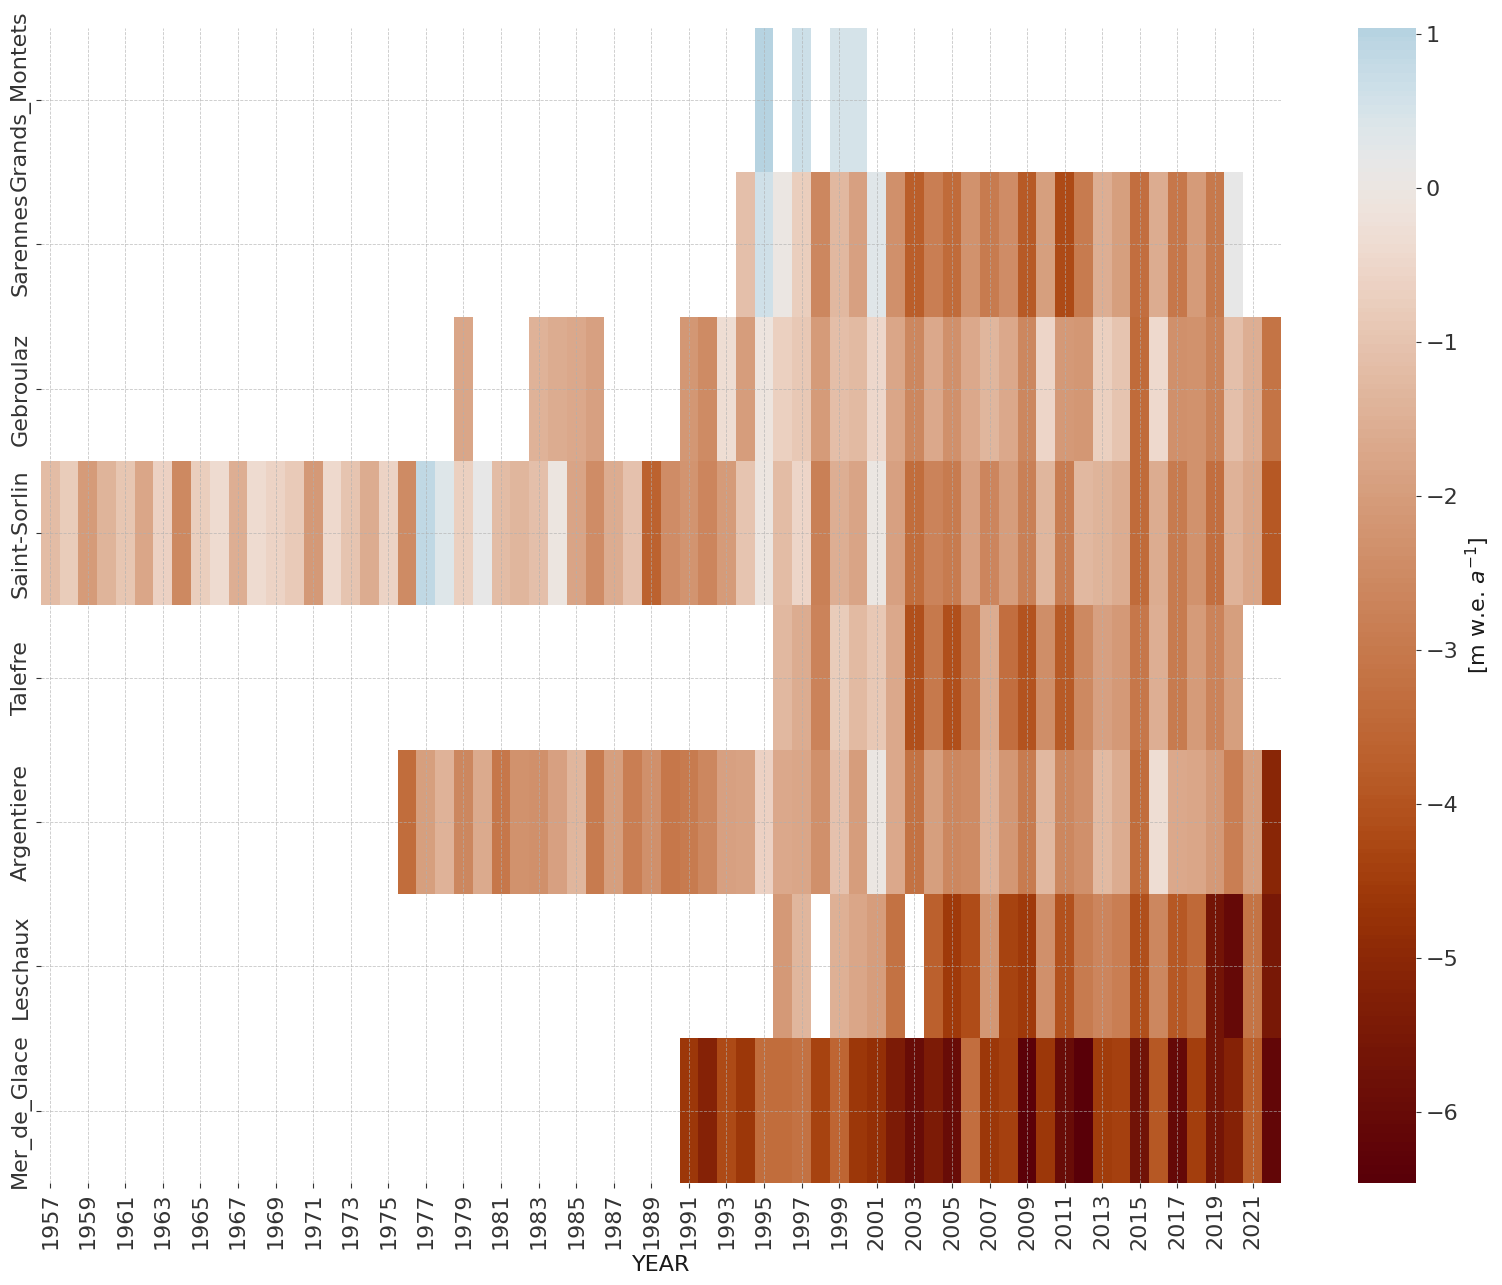

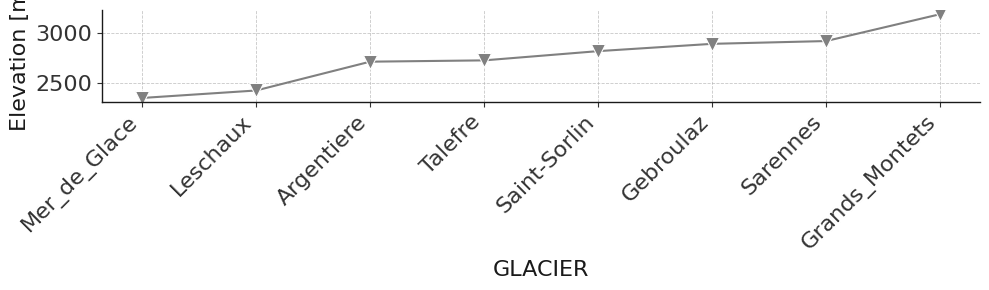

In [4]:
# Heatmap of mean mass balance per glacier:
# Get the mean mass balance per glacier

mean_mb_per_glacier = data_glacioclim.copy()
mean_mb_per_glacier['YEAR'] = mean_mb_per_glacier['TO_DATE'].astype(str).str[:4].astype(int)

mean_mb_per_glacier = mean_mb_per_glacier.groupby(
    ['GLACIER', 'YEAR', 'PERIOD'])['POINT_BALANCE'].mean().reset_index()
mean_mb_per_glacier = mean_mb_per_glacier[mean_mb_per_glacier['PERIOD'] == 'annual']

matrix = mean_mb_per_glacier.pivot(
    index='GLACIER', columns='YEAR',
    values='POINT_BALANCE').sort_values(by='GLACIER')

# get elevation of glaciers:
gl_per_el = data_glacioclim.groupby(['GLACIER'])['POINT_ELEVATION'].mean()
gl_per_el = gl_per_el.sort_values(ascending=False)

# Order matrix:
matrix = matrix.loc[gl_per_el.index]
matrix.index = pd.Categorical(matrix.index,
                              categories=matrix.index,
                              ordered=True)

# Plot heatmap:
fig = plt.figure(figsize=(20, 15))
ax = plt.subplot(1, 1, 1)
heatmap = sns.heatmap(
    data=matrix,
    center=0,
    cmap=cm.vik_r,
    cbar_kws={'label': '[m w.e. $a^{-1}$]'},
    ax=ax,
)

# Plot elevation:
fig = plt.figure(figsize=(10, 3))  # Made figure slightly taller for labels
ax = plt.subplot(1, 1, 1)
sorted_elevations = gl_per_el.sort_values(ascending=True)

sns.lineplot(sorted_elevations,
             ax=ax,
             color='gray',
             marker='v')

# Add glacier names as x-tick labels
ax.set_xticks(range(len(sorted_elevations)))
ax.set_xticklabels(sorted_elevations.index, rotation=45, ha='right')
ax.set_ylabel('Elevation [m]')
plt.tight_layout()

#### Input Dataset

In [5]:
data_glacioclim_test = data_glacioclim.copy()

print(data_glacioclim_test.shape)

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': path_PMB_GLACIOCLIM_csv,
    'era5_climate_data': path_ERA5_raw + 'era5_monthly_averaged_data_scratch.nc',
    'geopotential_data': path_ERA5_raw + 'era5_geopotential_pressure_scratch.nc'
    #'radiation_save_path': path_pcsr + 'csv/'
}

RUN = False
dataloader_gl = process_or_load_data_glacioclim(run_flag=RUN,
                                     df=data_glacioclim_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical)
data_monthly = dataloader_gl.data

print(data_monthly.shape)

(10623, 18)


2025-04-24 06:58:29,342 - INFO - Loaded preprocessed data.
2025-04-24 06:58:29,346 - INFO - Number of monthly rows: 92707
2025-04-24 06:58:29,360 - INFO - Number of annual rows: 54746
2025-04-24 06:58:29,368 - INFO - Number of winter rows: 24565


(92707, 29)


In [6]:
display(data_monthly.head(2))
display('------------------')
display(data_glacioclim_test['GLACIER'].unique())
display(data_monthly['GLACIER'].unique())
display('----------LANGUE GLACIER ZONE--------')
display(data_monthly[data_monthly['GLACIER_ZONE'] == 'Langue'].head(2))

display('----------STSO------------')
display(data_monthly[data_monthly['POINT_ID'] == 'stso_annual_smb_abl_2007_setup2006_6'].columns)


YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
0  2006   7.024819  45.944607          -0.67       2524.444781   
1  2006   7.024819  45.944607          -0.67       2524.444781   

   ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  \
0            509.075219          3033.52  RGI60-11.03638   
1            509.075219          3033.52  RGI60-11.03638   

                                            POINT_ID  ID  ...  millan_v  \
0  Argentiere_Tour_Noir_annual_smb_abl_2006_setup...   0  ...  5.479116   
1  Argentiere_Tour_Noir_annual_smb_abl_2006_setup...   0  ...  5.479116   

        t2m        tp          slhf           sshf          ssrd       fal  \
0  1.863512  0.002194 -1.039061e+06 -437717.194726  1.075649e+07  0.497858   
1 -5.253318  0.001675 -2.778184e+05 -212737.035722  7.246017e+06  0.564715   

            str       u10       v10  
0 -3.961348e+06 -0.321163  0.331876  
1 -3.621123e+06 -0.175581  0.153386  

[2 rows x 29 columns]

'------------------'

array(['Argentiere', 'Gebroulaz', 'Grands_Montets', 'Leschaux',
       'Mer_de_Glace', 'Saint-Sorlin', 'Sarennes', 'Talefre'],
      dtype=object)

array(['Argentiere', 'Gebroulaz', 'Grands_Montets', 'Leschaux',
       'Mer_de_Glace', 'Saint-Sorlin', 'Sarennes', 'Talefre'],
      dtype=object)

'----------LANGUE GLACIER ZONE--------'

YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
48298  1996   6.942335   45.90707          -5.49       2336.982377   
48299  1996   6.942335   45.90707          -5.49       2336.982377   

       ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  \
48298           -262.052377          2074.93  RGI60-11.03643   
48299           -262.052377          2074.93  RGI60-11.03643   

                                         POINT_ID    ID  ...   millan_v  \
48298  mdg_langue_annual_smb_abl_1996_setup1995_1  5598  ...  27.030954   
48299  mdg_langue_annual_smb_abl_1996_setup1995_1  5598  ...  27.030954   

            t2m        tp           slhf           sshf          ssrd  \
48298 -6.309711  0.003661 -312689.854211 -337923.512459  7.617317e+06   
48299 -9.915834  0.005198  -12605.208002  -37780.681824  5.046278e+06   

            fal           str       u10       v10  
48298  0.561271 -3.394249e+06 -0.479726  0.192167  
48299  0.687231 -1.889281e+06 -0.596192  0.465043  

[2 rows x 29 columns]

'----------STSO------------'

Index(['YEAR', 'POINT_LON', 'POINT_LAT', 'POINT_BALANCE', 'ALTITUDE_CLIMATE',
       'ELEVATION_DIFFERENCE', 'POINT_ELEVATION', 'RGIId', 'POINT_ID', 'ID',
       'N_MONTHS', 'MONTHS', 'PERIOD', 'GLACIER', 'GLACIER_ZONE', 'aspect',
       'slope', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v', 't2m',
       'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'],
      dtype='object')

#### Nr. of measurements per year

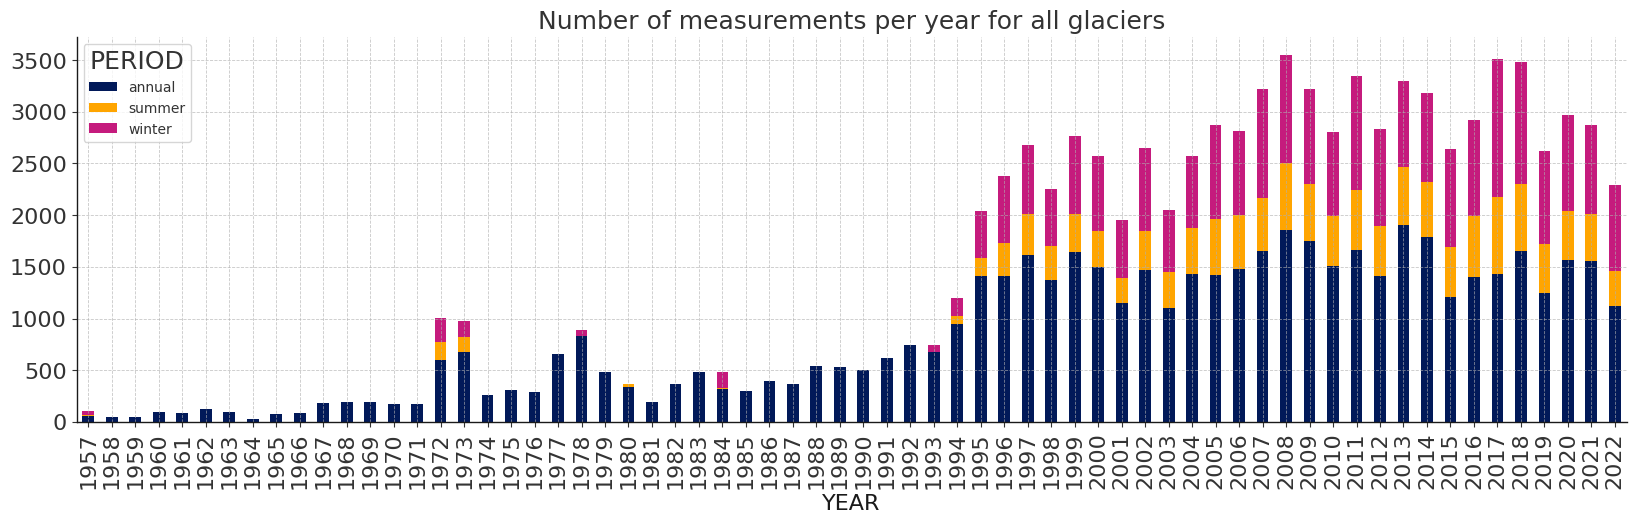

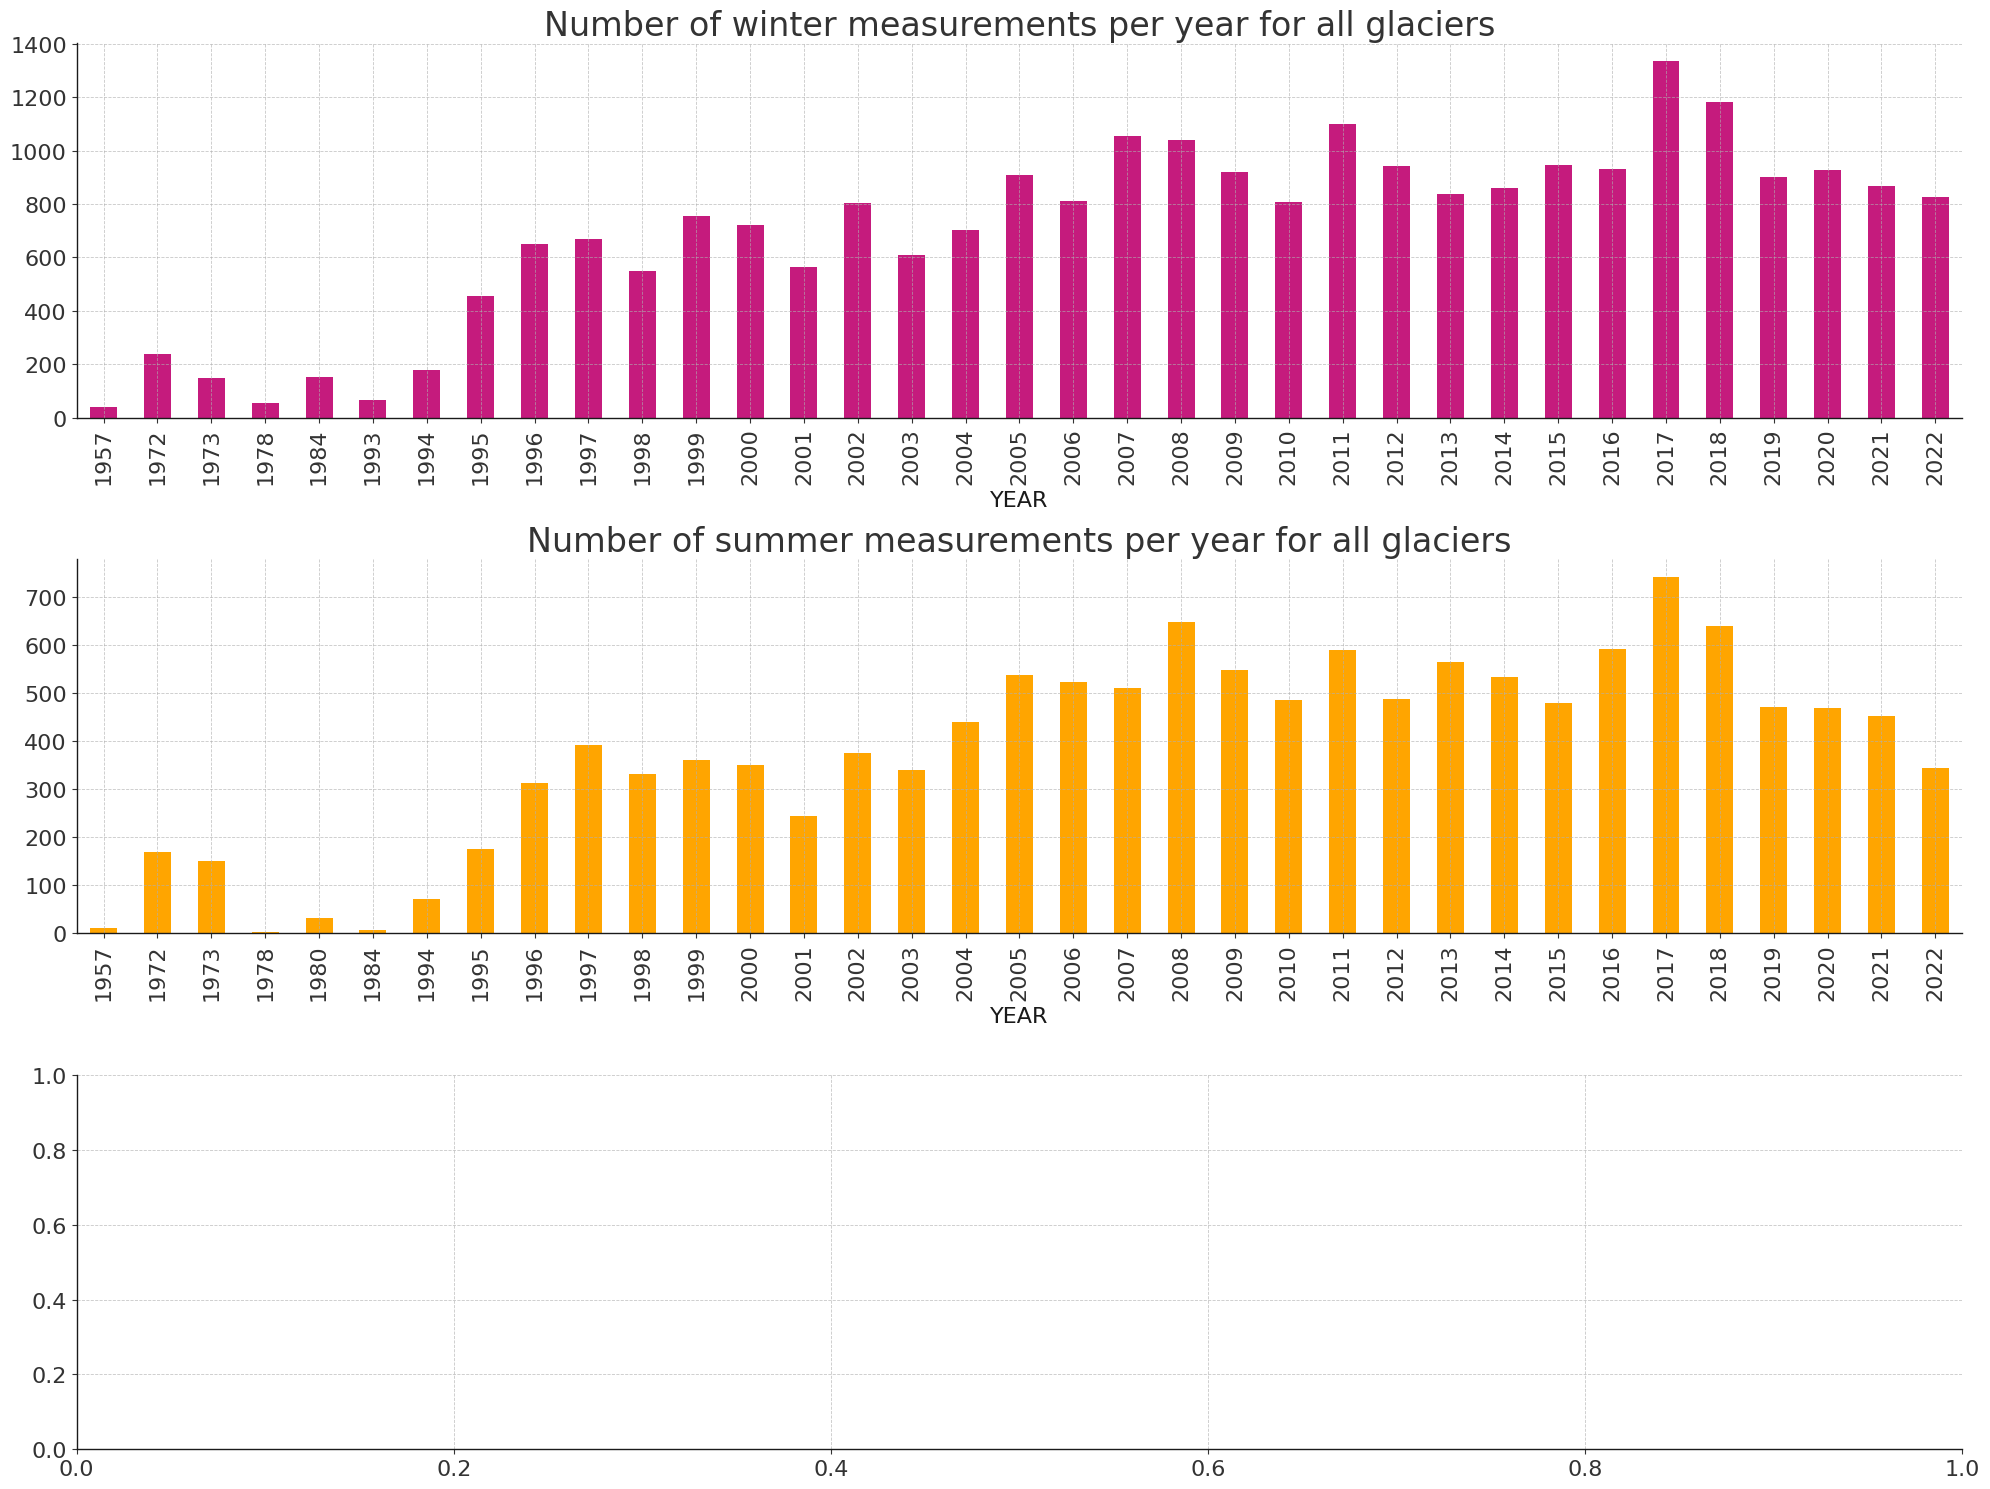

In [7]:
# Number of measurements per year:
data_monthly.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar',
    stacked=True,
    figsize=(20, 5),
    color=[color_dark_blue, color_orange, color_pink])
plt.title('Number of measurements per year for all glaciers')

# Plot winter, summer and annual separately:
fig, axs = plt.subplots(3, 1, figsize=(20, 15), sharey=False)

# Winter plot
data_monthly[data_monthly.PERIOD == 'winter'].groupby(
    ['YEAR', 'PERIOD']).size().unstack().plot(
        kind='bar',
        ax=axs[0],
        color=[color_pink],
        legend=False)
axs[0].set_title('Number of winter measurements per year for all glaciers',
                 fontsize=24)

# Summer plot
data_monthly[data_monthly.PERIOD == 'summer'].groupby(
    ['YEAR', 'PERIOD']).size().unstack().plot(
        kind='bar',
        ax=axs[1],
        color=[color_orange],
        legend=False)
axs[1].set_title('Number of summer measurements per year for all glaciers',
                 fontsize=24)

"""
# Annual plot 
data_monthly[data_monthly.PERIOD == 'annual'].groupby(
    ['YEAR', 'PERIOD']).size().unstack().plot(
        kind='bar',
        ax=axs[2], 
        color=[color_dark_blue],
        legend=False)
axs[2].set_title('Number of annual measurements per year for all glaciers',
                 fontsize=24)
"""

plt.tight_layout()

### Correction for elevation difference:

In [52]:
"""
### NO GLOGEM DATA

# Load and preprocess GloGEM factors
path_glogem_factors = os.path.join(path_glogem, 'reference_run_GloGEM2024.csv')
glogem_factors = pd.read_csv(path_glogem_factors)
glogem_factors.rename(columns={'ID': 'RGIId'}, inplace=True)
glogem_factors['RGIId'] = glogem_factors['RGIId'].apply(
    lambda x: format_rgi_code(x))

c_prec_dic, t_off_dic = {}, {}
for gl in data_monthly.GLACIER.unique():
    rgi_gl = data_monthly[data_monthly.GLACIER == gl].RGIId.unique()[0]
    factor_gl = glogem_factors[glogem_factors.RGIId == rgi_gl]
    c_prec_dic[gl] = factor_gl['Cprec'].values[0]
    t_off_dic[gl] = factor_gl['T_off'].values[0]

# Mean of dic values
mean_c_prec = np.max(list(c_prec_dic.values()))
mean_t_off = np.max(list(t_off_dic.values()))
print(f"Mean Cprec: {mean_c_prec}, Mean T_off: {mean_t_off}")

# Correct t2m and tp for elevation
dataloader_gl.correct_for_elevation()

# Plot the distribution of corrected and uncorrected precipitation and temperature
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Precipitation
sns.histplot(data_monthly['tp'],
             bins=50,
             kde=True,
             label='tp',
             alpha=0.5,
             ax=axes[0])
sns.histplot(data_monthly['tp_corr'],
             bins=50,
             kde=True,
             label='tp_corr',
             alpha=0.5,
             ax=axes[0])
axes[0].set_title('Distribution of Precipitation')
axes[0].set_xlabel('Precipitation (tp / tp_corr)')
axes[0].legend()

# Temperature
sns.histplot(data_monthly['t2m'],
             bins=50,
             kde=True,
             label='t2m',
             alpha=0.5,
             ax=axes[1])
sns.histplot(data_monthly['t2m_corr'],
             bins=50,
             kde=True,
             label='t2m_corr',
             alpha=0.5,
             ax=axes[1])
axes[1].set_title('Distribution of Temperature')
axes[1].set_xlabel('Temperature (t2m / t2m_corr)')
axes[1].legend()

plt.tight_layout()
plt.show()
"""

'\n### NO GLOGEM DATA\n\n# Load and preprocess GloGEM factors\npath_glogem_factors = os.path.join(path_glogem, \'reference_run_GloGEM2024.csv\')\nglogem_factors = pd.read_csv(path_glogem_factors)\nglogem_factors.rename(columns={\'ID\': \'RGIId\'}, inplace=True)\nglogem_factors[\'RGIId\'] = glogem_factors[\'RGIId\'].apply(\n    lambda x: format_rgi_code(x))\n\nc_prec_dic, t_off_dic = {}, {}\nfor gl in data_monthly.GLACIER.unique():\n    rgi_gl = data_monthly[data_monthly.GLACIER == gl].RGIId.unique()[0]\n    factor_gl = glogem_factors[glogem_factors.RGIId == rgi_gl]\n    c_prec_dic[gl] = factor_gl[\'Cprec\'].values[0]\n    t_off_dic[gl] = factor_gl[\'T_off\'].values[0]\n\n# Mean of dic values\nmean_c_prec = np.max(list(c_prec_dic.values()))\nmean_t_off = np.max(list(t_off_dic.values()))\nprint(f"Mean Cprec: {mean_c_prec}, Mean T_off: {mean_t_off}")\n\n# Correct t2m and tp for elevation\ndataloader_gl.correct_for_elevation()\n\n# Plot the distribution of corrected and uncorrected precipi

### Feature correlation:

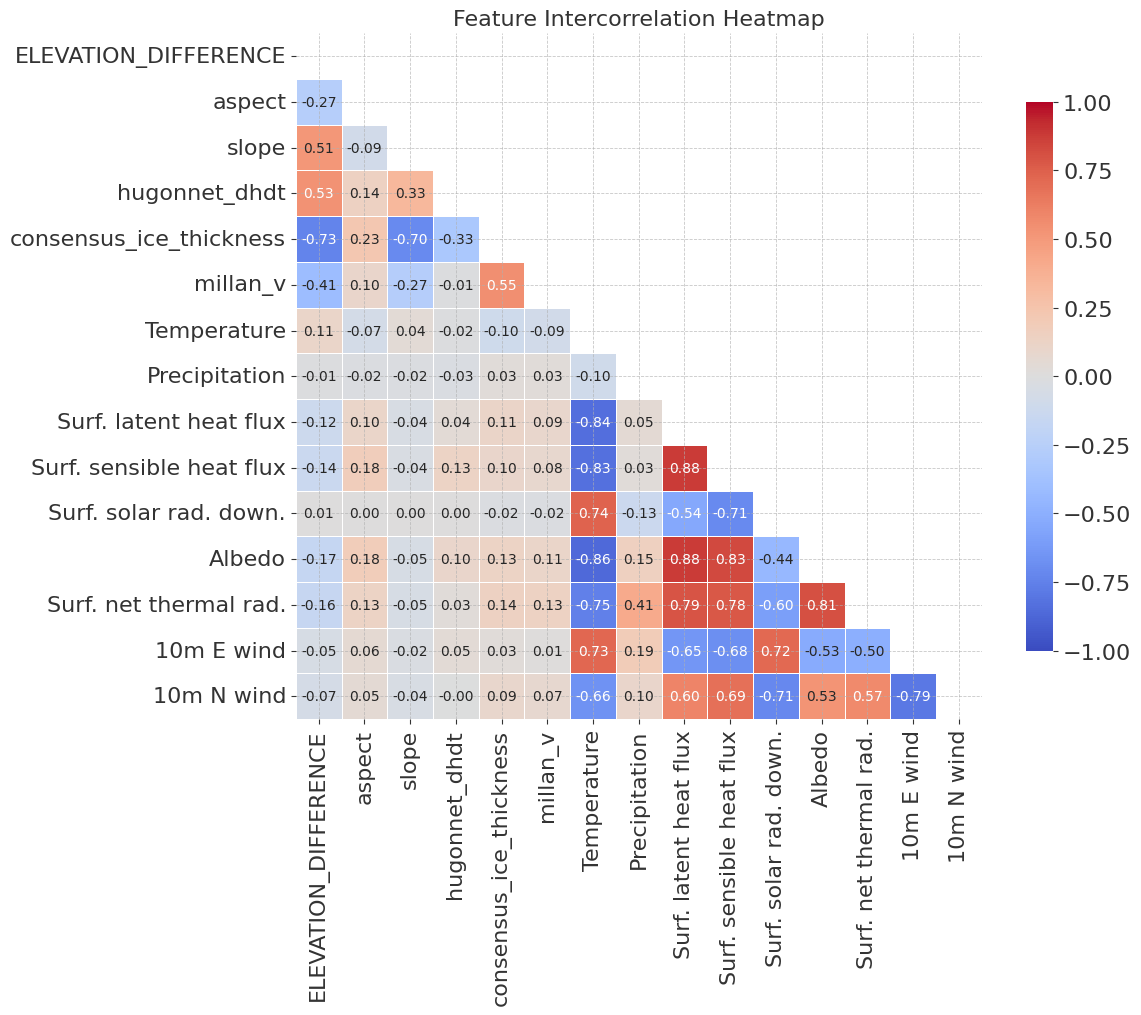

In [8]:
# Prepare data for correlation analysis
df = dataloader_gl.data.copy().dropna()

# Define the columns to keep
columns_to_keep = [
    col for col in df.columns if col not in [
        'GLACIER', 'PERIOD', 'YEAR', 'POINT_LON', 'POINT_LAT', 'POINT_BALANCE',
        'ALTITUDE_CLIMATE', 'POINT_ELEVATION', 'RGIId', 'POINT_ID', 'ID',
        'N_MONTHS', 'MONTHS', 'GLACIER_ZONE'
    ]
]
df = df[columns_to_keep]

# Rename columns based on long names (if applicable)
df.rename(columns=vois_climate_long_name, inplace=True)

# Compute correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the heatmap
sns.heatmap(
    corr,
    mask=mask,
    cmap='coolwarm',
    vmax=1,
    vmin=-1,
    center=0,
    annot=True,  # Add correlation values
    fmt=".2f",
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": 0.8})

# Enhance readability
plt.title("Feature Intercorrelation Heatmap", fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()

### Sanity checks:

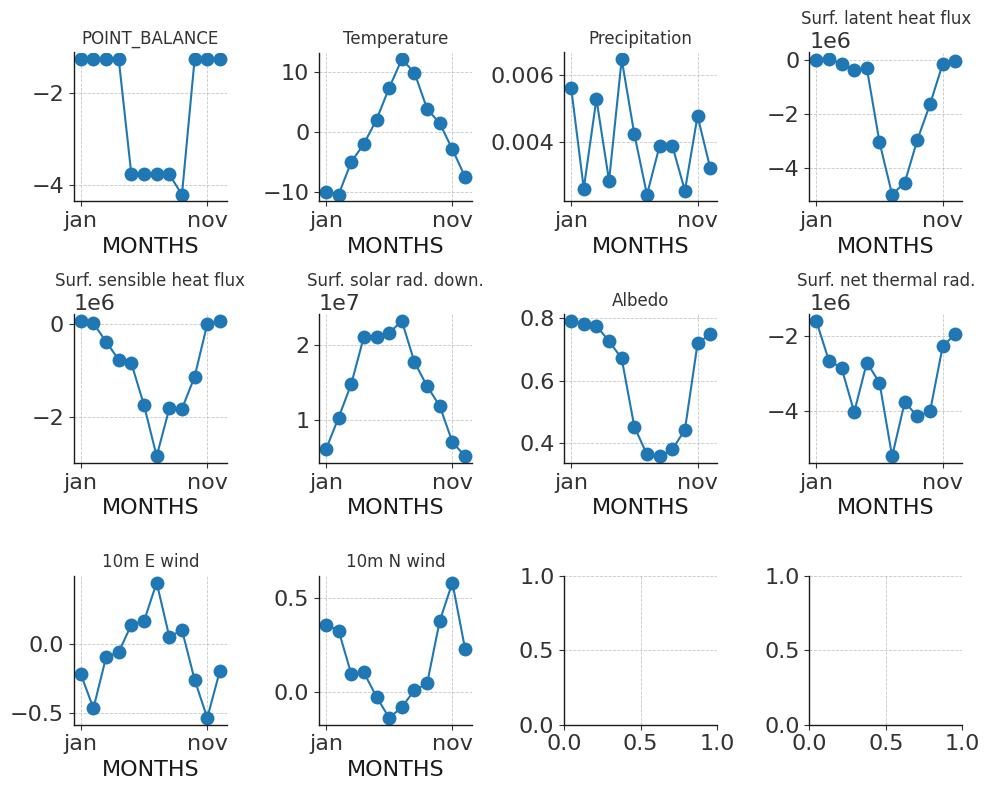

In [9]:
# Sanity check of variables:
df = dataloader_gl.data
var_to_plot = ['POINT_BALANCE'] + vois_climate
df = df[(df.GLACIER == 'Argentiere') & (df.YEAR == 2015)].groupby(
    ['MONTHS'])[var_to_plot].mean().reset_index()
df['month_nb'] = df.MONTHS.apply(
    lambda x: list(month_abbr).index(x.capitalize()))
df.sort_values(by='month_nb', inplace=True)
fig, ax = plt.subplots(3, 4, figsize=(10, 8))

for i, var in enumerate(var_to_plot):
    df.plot(x='MONTHS', y=var, marker='o', ax=ax.flatten()[i], legend=False)
    if var in vois_climate_long_name.keys():
        ax.flatten()[i].set_title(vois_climate_long_name[var], fontsize=12)
    else:
        ax.flatten()[i].set_title(var, fontsize=12)
plt.tight_layout()

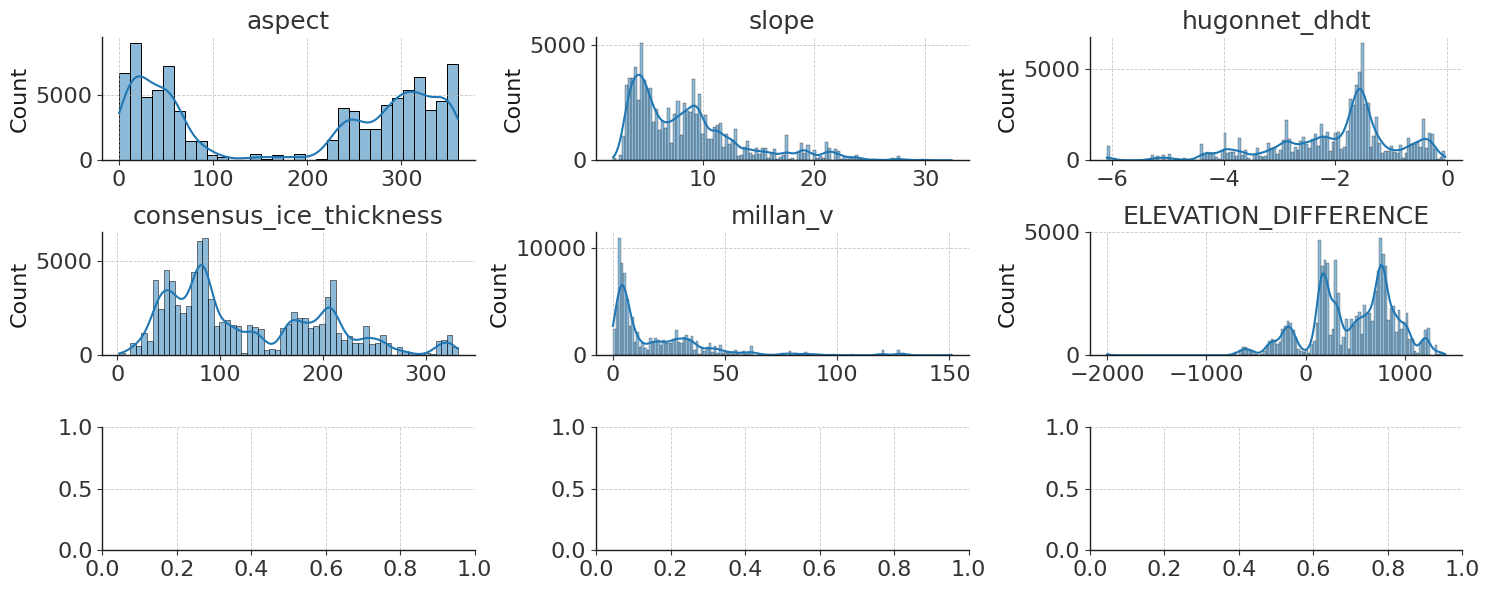

In [10]:
# Plot the distribution of the topo variables:
df = dataloader_gl.data
fig, axs = plt.subplots(3, 3, figsize=(15, 6))
for i, var in enumerate(vois_topographical + ['ELEVATION_DIFFERENCE']):
    ax = axs.flatten()[i]
    sns.histplot(df[var], ax=ax, kde=True)
    ax.set_xlabel('')
    ax.set_title(var)
plt.tight_layout()

## Blocking on glaciers:
### Spatial Cross-Validation

In [ ]:
test_glaciers = ['Gebroulaz']

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers correctly
train_glaciers = [i for i in existing_glaciers if i not in test_glaciers]

data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]
print('Size of test data:', len(data_test))

data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))

if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

# Number of annual versus winter measurements:
print('Train:')
print('Number of winter, summer and annual samples:', len(data_train))
print('Number of annual samples:',
      len(data_train[data_train.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_train[data_train.PERIOD == 'winter']))
print('Number of summer samples:',
      len(data_train[data_train.PERIOD == 'summer']))

# Same for test
data_test_annual = data_test[data_test.PERIOD == 'annual']
data_test_winter = data_test[data_test.PERIOD == 'winter']
data_test_summer = data_test[data_test.PERIOD == 'summer']

print('Test:')
print('Number of winter, summer and annual samples:', len(data_test))
print('Number of annual samples:', len(data_test_annual))
print('Number of winter samples:', len(data_test_winter))
print('Number of summer samples:', len(data_test_summer))

print('Total:')
print('Number of monthly rows:', len(dataloader_gl.data))
print('Number of annual rows:',
      len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'annual']))
print('Number of winter rows:',
      len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'winter']))
print('Number of summer rows:',
      len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'summer']))

#### Heatmap annual:

In [ ]:
plotHeatmap(test_glaciers, data_glacioclim, period='annual')

#### Heatmap winter:

In [ ]:
plotHeatmap(test_glaciers, data_glacioclim, period='winter')

In [ ]:
plotHeatmap(test_glaciers, data_glacioclim, period='summer')

#### Spatial Glacier based CV splits:

In [ ]:
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)

print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))
test_perc = (len(test_set['df_X']) / len(train_set['df_X'])) * 100
print('Percentage of test size: {:.2f}%'.format(test_perc))
print('Size of test set:', len(test_set['df_X']))
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                       train_set['splits_vals']))
print('Size of train set:', len(train_set['df_X']))

visualiseSplits(test_set['y'], train_set['y'], splits)
visualiseInputs(train_set, test_set, vois_climate)

#### Stake based CV Splits

In [ ]:
## This is a split by POINT_ID, the problem is that POINT_ID is not synonymous with the actual stakes, but unique for every measurement.
## So in the end there will be the same stake with different POINT_IDs for different years, this means that the same stake might be in the train and test set.
## This is more out of curiosity though anyways, we are not really going for single stake predictions.


splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='POINT_ID',
                                            test_splits=None,
                                            random_state=cfg.seed,
                                            test_size=0.2)

print('Test stakes: ({}) {}'.format(
    len(test_set['splits_vals']), 
    test_set['splits_vals'][:5] if len(test_set['splits_vals']) > 5 else test_set['splits_vals'])
)
if len(test_set['splits_vals']) > 5:
    print('... and {} more stakes'.format(len(test_set['splits_vals']) - 5))

test_perc = (len(test_set['df_X']) / len(train_set['df_X'])) * 100
print('Percentage of test size: {:.2f}%'.format(test_perc))
print('Size of test set:', len(test_set['df_X']))
print('Size of train set:', len(train_set['df_X']))

test_stakes_by_glacier = test_set['df_X'].groupby('GLACIER')['POINT_ID'].nunique()
print('\nTest stakes distribution by glacier:')
for glacier, count in test_stakes_by_glacier.items():
    print(f"  {glacier}: {count} stakes")


visualiseSplits(test_set['y'], train_set['y'], splits)
visualiseInputs(train_set, test_set, vois_climate)


#### Temporal CV Split

In [ ]:
# Remove last 5 years of data and use as test set

test_years_count = 5

all_years = sorted(dataloader_gl.data['YEAR'].unique())

# Use the most recent years as test data
train_years = all_years[:-test_years_count]
test_years = all_years[-test_years_count:]

print(f"Training on years: {train_years}")
print(f"Testing on years: {test_years}")

splits, test_set, train_set = get_CV_splits(
                                dataloader_gl,
                                test_split_on='YEAR',
                                test_splits=test_years,
                                random_state=cfg.seed)

print('Test years: {}'.format(test_set['splits_vals']))
test_perc = (len(test_set['df_X']) / len(train_set['df_X'])) * 100
print('Percentage of test size: {:.2f}%'.format(test_perc))
print('Size of test set:', len(test_set['df_X']))
print('Train years: {}'.format(train_set['splits_vals']))
print('Size of train set:', len(train_set['df_X']))


test_samples_by_year = test_set['df_X'].groupby(['YEAR', 'PERIOD']).size()
print('\nTest samples by year and period:')
print(test_samples_by_year)

visualiseSplits(test_set['y'], train_set['y'], splits)
visualiseInputs(train_set, test_set, vois_climate)
    


#### Split train CH and test FR

In [11]:
display(data_monthly.head(2))

data_monthly_CH = pd.read_csv('/home/mburlet/scratch/data/GLAMOS/point/csv/CH_wgms_dataset_monthly_full.csv')

data_monthly_CH = data_monthly_CH.drop(columns=['pcsr'])
column_mapping = {'aspect_sgi': 'aspect', 'slope_sgi': 'slope'}
data_monthly_CH = data_monthly_CH.rename(columns=column_mapping)
data_monthly_CH['GLACIER_ZONE'] = 'Placeholder'

display(data_monthly_CH.head(2))

data_monthly = data_monthly[data_monthly['PERIOD'] != 'summer']

display(data_monthly['PERIOD'].unique())

display(type(data_monthly))

YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
0  2006   7.024819  45.944607          -0.67       2524.444781   
1  2006   7.024819  45.944607          -0.67       2524.444781   

   ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  \
0            509.075219          3033.52  RGI60-11.03638   
1            509.075219          3033.52  RGI60-11.03638   

                                            POINT_ID  ID  ...  millan_v  \
0  Argentiere_Tour_Noir_annual_smb_abl_2006_setup...   0  ...  5.479116   
1  Argentiere_Tour_Noir_annual_smb_abl_2006_setup...   0  ...  5.479116   

        t2m        tp          slhf           sshf          ssrd       fal  \
0  1.863512  0.002194 -1.039061e+06 -437717.194726  1.075649e+07  0.497858   
1 -5.253318  0.001675 -2.778184e+05 -212737.035722  7.246017e+06  0.564715   

            str       u10       v10  
0 -3.961348e+06 -0.321163  0.331876  
1 -3.621123e+06 -0.175581  0.153386  

[2 rows x 29 columns]

YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
0  2006   7.855896  46.010637         -2.592       2787.508638   
1  2006   7.855896  46.010637         -2.592       2787.508638   

   ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  POINT_ID  ID  ...  \
0            308.999104      3096.507742  RGI60-11.02764  adler_28   0  ...   
1            308.999104      3096.507742  RGI60-11.02764  adler_28   0  ...   

         t2m        tp           slhf           sshf          ssrd       fal  \
0  -7.534975  0.001175 -176999.405490 -243462.317031  7.256997e+06  0.678897   
1 -14.348139  0.002283   31280.688874  217670.830543  5.847847e+06  0.818081   

            str       u10       v10  GLACIER_ZONE  
0 -2.764534e+06  0.548619  0.054795   Placeholder  
1 -1.811733e+06  1.031728 -0.189422   Placeholder  

[2 rows x 30 columns]

array(['annual', 'winter'], dtype=object)

pandas.core.frame.DataFrame

Test glaciers in FR: (8) ['Argentiere' 'Gebroulaz' 'Grands_Montets' 'Leschaux' 'Mer_de_Glace'
 'Saint-Sorlin' 'Sarennes' 'Talefre']
Train glaciers in CH: (32) ['adler' 'albigna' 'aletsch' 'allalin' 'basodino' 'clariden' 'corbassiere'
 'corvatsch' 'findelen' 'forno' 'gietro' 'gorner' 'gries' 'hohlaub'
 'joeri' 'limmern' 'morteratsch' 'murtel' 'oberaar' 'otemma' 'pizol'
 'plainemorte' 'plattalva' 'rhone' 'sanktanna' 'schwarzbach' 'schwarzberg'
 'sexrouge' 'silvretta' 'taelliboden' 'tortin' 'tsanfleuron']
Size of test set: 79311
Size of train set: 281110


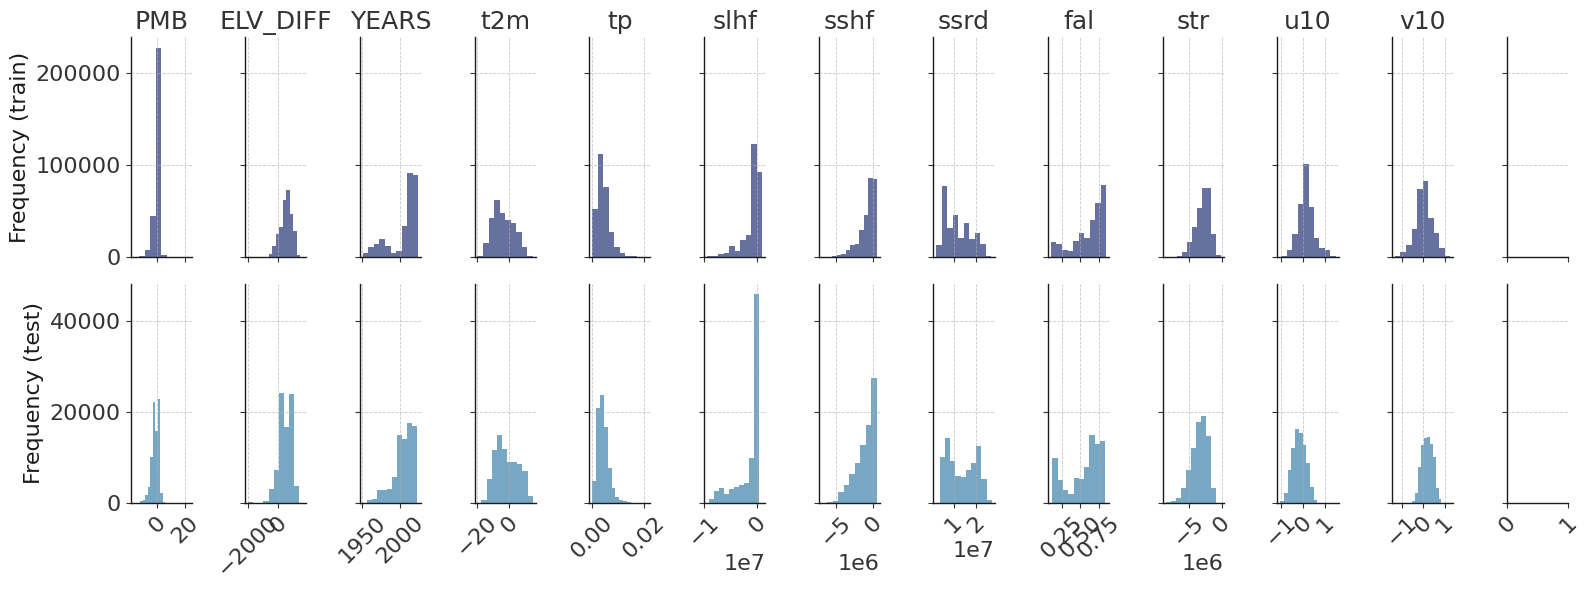

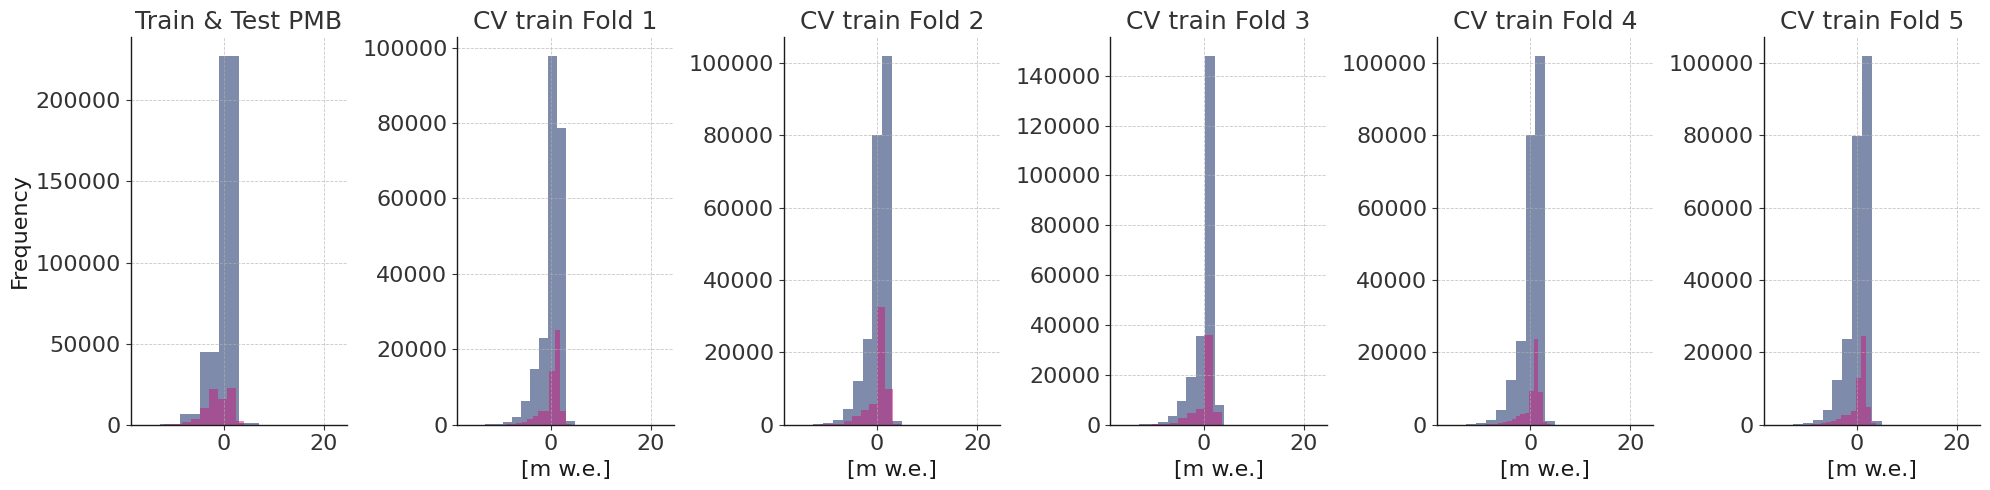

In [12]:
# Train set (Swiss data)
df_X_train = data_monthly_CH
y_train = df_X_train['POINT_BALANCE'].values
train_meas_id = df_X_train['ID'].unique()
train_splits = df_X_train['GLACIER'].unique()

# Test set (French data)
df_X_test = data_monthly
y_test = df_X_test['POINT_BALANCE'].values
test_meas_id = df_X_test['ID'].unique()
test_splits = df_X_test['GLACIER'].unique()

test_set = {
    'df_X': df_X_test,
    'y': y_test,
    'meas_id': test_meas_id,
    'splits_vals': test_splits
}

train_set = {
    'df_X': df_X_train,
    'y': y_train,
    'splits_vals': train_splits,
    'meas_id': train_meas_id,
}

# Have to create a dataloader so i can use get_cv_split()
dataloader_CH = mbm.DataLoader(cfg, 
                              data=data_monthly_CH,
                              random_seed=cfg.seed,
                              meta_data_columns=cfg.metaData)


train_indices = data_monthly_CH.index
test_indices = pd.Index([]) 

dataloader_CH.set_custom_train_test_indices(train_indices, test_indices)


splits = dataloader_CH.get_cv_split(n_splits=5, type_fold='group-meas-id')

print('Test glaciers in FR: ({}) {}'.format(len(test_set['splits_vals']), test_set['splits_vals']))
print('Train glaciers in CH: ({}) {}'.format(len(train_set['splits_vals']), train_set['splits_vals']))

print('Size of test set:', len(test_set['df_X']))
print('Size of train set:', len(train_set['df_X']))


visualiseInputs(train_set, test_set, vois_climate)
visualiseSplits(test_set['y'], train_set['y'], splits)

Text(0.5, 1.02, 'Feature Distributions: Training Set vs Test Glaciers')

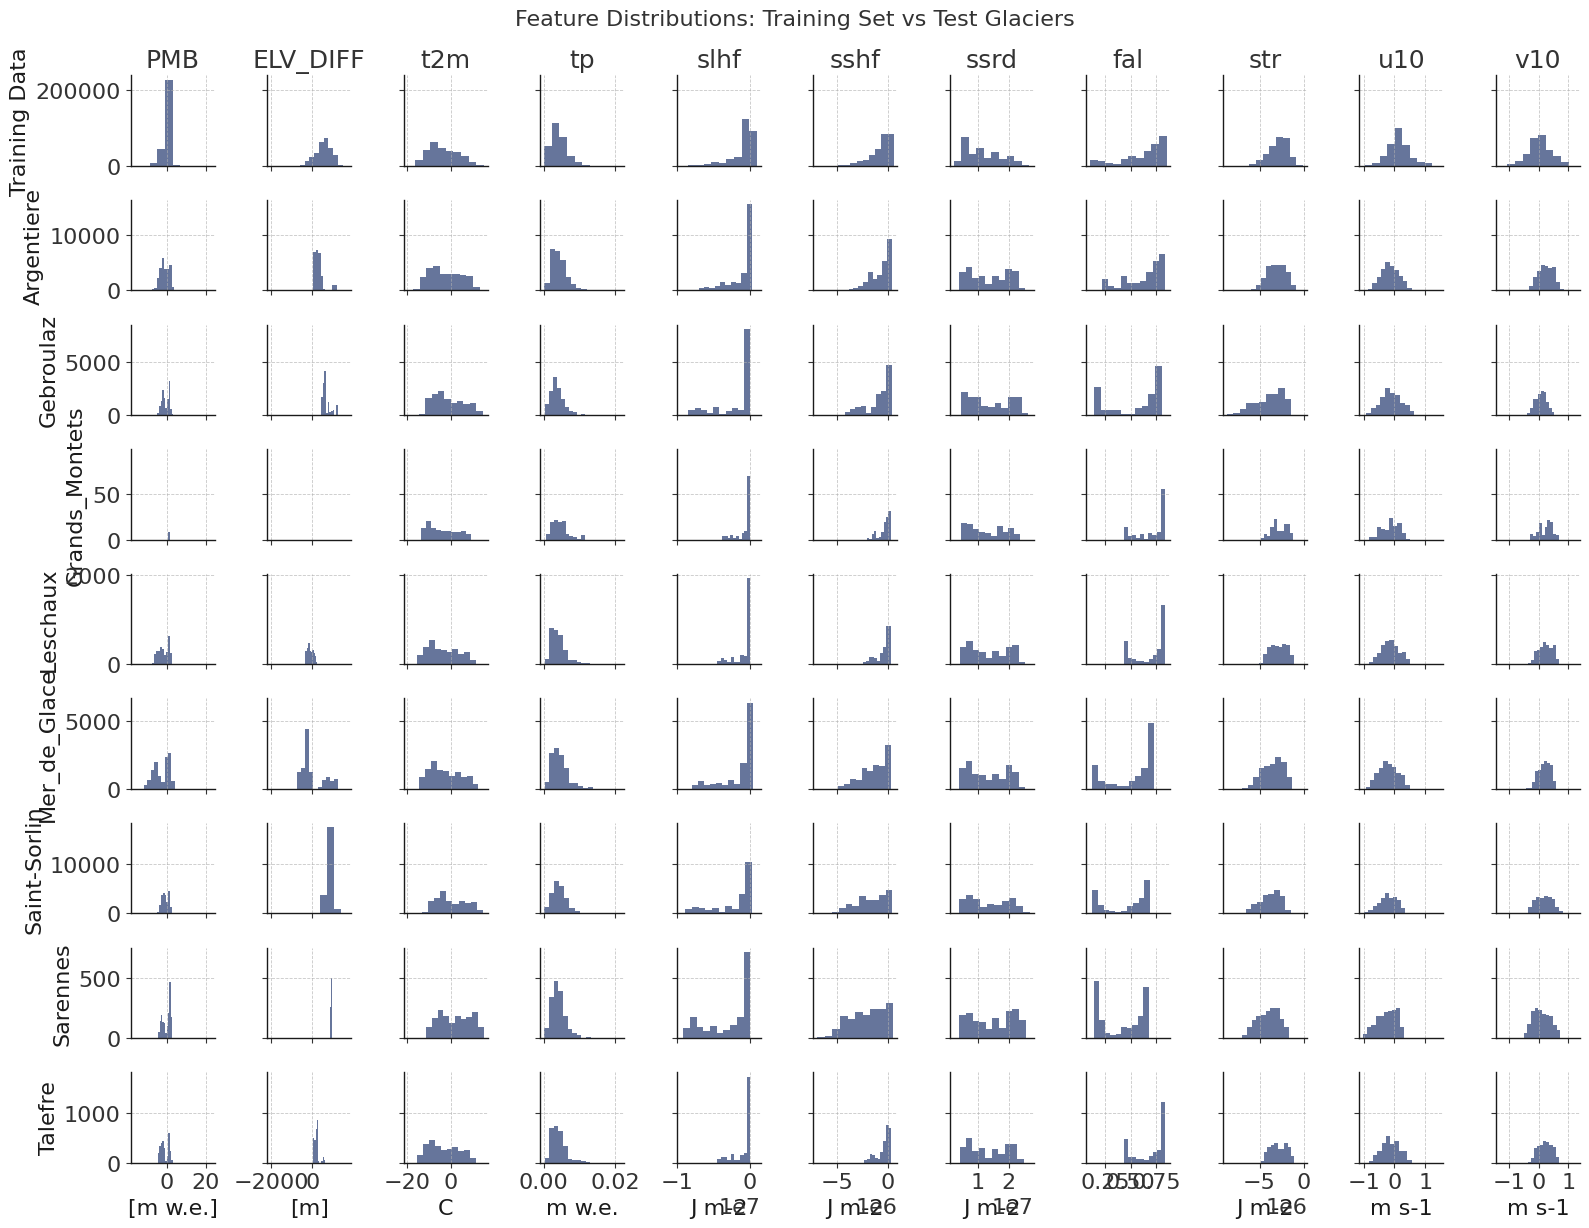

In [13]:
test_glaciers = test_splits

# Plot distributions of test glaciers with train data as first row
n_rows = len(test_glaciers) + 1 
f, ax = plt.subplots(n_rows,
                     len(vois_climate) + 2,
                     figsize=(16, 12),
                     sharey='row',
                     sharex='col')

# Plot the training data in the first row
train_df = train_set['df_X']  # All training data
train_df['POINT_BALANCE'].plot.hist(ax=ax[0, 0],
                                    color=color_xgb,  # Use same color as in visualiseInputs
                                    alpha=0.6,
                                    density=False)
ax[0, 0].set_title('PMB')
ax[0, 0].set_ylabel('Training Data')
ax[0, 0].set_xlabel('[m w.e.]')

train_df['ELEVATION_DIFFERENCE'].plot.hist(ax=ax[0, 1],
                                           color=color_xgb,
                                           alpha=0.6,
                                           density=False)
ax[0, 1].set_title('ELV_DIFF')
ax[0, 1].set_xlabel('[m]')

for j, voi_clim in enumerate(vois_climate):
    ax[0, 2 + j].set_title(voi_clim)
    train_df[voi_clim].plot.hist(ax=ax[0, 2 + j],
                                 color=color_xgb,
                                 alpha=0.6,
                                 density=False)
    ax[0, 2 + j].set_xlabel(vois_units[voi_clim])

# Plot the test glaciers
for i, test_gl in enumerate(test_glaciers):
    row_idx = i + 1  # Offset by 1 for the training data row
    test_df_gl = test_set['df_X'][test_set['df_X'].GLACIER == test_gl]
    test_df_gl['POINT_BALANCE'].plot.hist(ax=ax[row_idx, 0],
                                          color=color_dark_blue,
                                          alpha=0.6,
                                          density=False)
    ax[row_idx, 0].set_ylabel(test_gl)
    ax[row_idx, 0].set_xlabel('[m w.e.]')
    
    test_df_gl['ELEVATION_DIFFERENCE'].plot.hist(ax=ax[row_idx, 1],
                                                 color=color_dark_blue,
                                                 alpha=0.6,
                                                 density=False)
    ax[row_idx, 1].set_xlabel('[m]')

    for j, voi_clim in enumerate(vois_climate):
        test_df_gl[voi_clim].plot.hist(ax=ax[row_idx, 2 + j],
                                       color=color_dark_blue,
                                       alpha=0.6,
                                       density=False)
        ax[row_idx, 2 + j].set_xlabel(vois_units[voi_clim])

plt.tight_layout()
plt.suptitle('Feature Distributions: Training Set vs Test Glaciers', 
             fontsize=16, y=1.02)

"Available variables and their corresponding var_labels:\n\n    Point Mass Balance:\n    - 'POINT_BALANCE' → 'PMB [m w.e.]'\n\n    Elevation:\n    - 'ELEVATION_DIFFERENCE' → 'Elevation Difference [m]'\n    - 'POINT_ELEVATION' → 'Elevation [m]'\n    - 'ALTITUDE_CLIMATE' → 'Climate Altitude [m]'\n\n    Climate Variables:\n    - 't2m' → 'Temperature [K]'\n    - 'tp' → 'Precipitation [mm]'\n    - 'slhf' → 'Surface Latent Heat Flux [W/m²]'\n    - 'sshf' → 'Surface Sensible Heat Flux [W/m²]'\n    - 'ssrd' → 'Surface Solar Radiation Downward [W/m²]'\n    - 'fal' → 'Forecast Albedo [-]'\n    - 'str' → 'Surface Thermal Radiation [W/m²]'\n    - 'u10' → 'Wind E [m/s]'\n    - 'v10' → 'Wind N [m/s]'\n\n    Topographical Variables:\n    - 'aspect' → 'Aspect [degrees]'\n    - 'slope' → 'Slope [degrees]'\n    - 'hugonnet_dhdt' → 'Ice Thickness Change Rate [m/yr]'\n    - 'consensus_ice_thickness' → 'Ice Thickness [m]'\n    - 'millan_v' → 'Ice Velocity [m/yr]'"

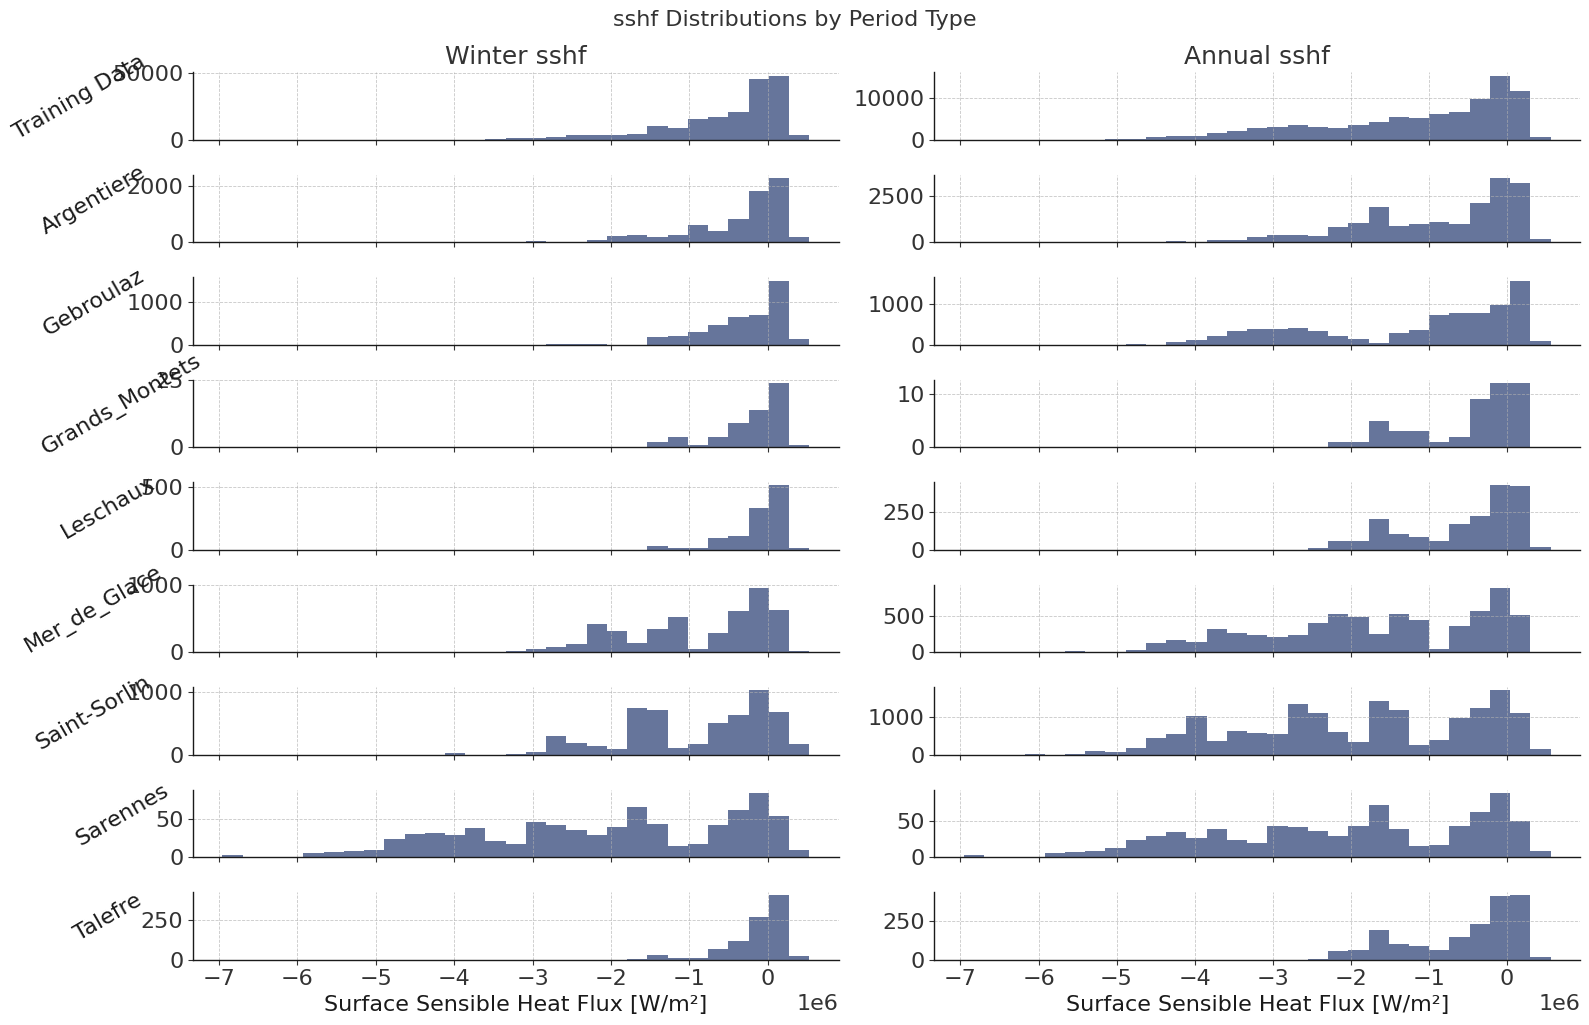

In [52]:
def plot_combined_distributions(test_glaciers, train_set, test_set, color_xgb, color_dark_blue, 
                               variable='POINT_BALANCE', var_label='PMB [m w.e.]',
                               period_titles=None):
    """
    Plot distributions of any variable for winter and annual periods.

    """
    # Set up plot with 2 columns - Winter and Annual
    n_rows = len(test_glaciers) + 1
    fig, axs = plt.subplots(n_rows, 2, figsize=(16, 10), sharex='col')
    
    periods = ['winter', 'annual']
    if period_titles is None:
        period_titles = [f'Winter {variable}', f'Annual {variable}']
    
    # For each period (column)
    for col, (period, title) in enumerate(zip(periods, period_titles)):
        # Filter by period
        train_df = train_set['df_X'][train_set['df_X']['PERIOD'] == period]
        
        # Calculate common bins for this period
        all_values = train_df[variable].values
        for test_gl in test_glaciers:
            test_df = test_set['df_X'][(test_set['df_X']['GLACIER'] == test_gl) & 
                                      (test_set['df_X']['PERIOD'] == period)]
            if len(test_df) > 0:
                all_values = np.concatenate([all_values, test_df[variable].values])
        
        if len(all_values) > 0:  # Check if there's data for this period
            bins = np.linspace(np.floor(min(all_values)), np.ceil(max(all_values)), 30)
            
            # Add column title
            axs[0, col].set_title(title)
            
            # Training data histogram (first row)
            train_df[variable].plot.hist(ax=axs[0, col], 
                                       color=color_xgb, 
                                       alpha=0.6, 
                                       bins=bins)

            # Remove "Frequency" y-axis label
            axs[0, col].set_ylabel("")
            
            # Only add y-label on the first column
            if col == 0:
                axs[0, col].set_ylabel('Training Data', rotation=30, labelpad=20)
            
            # Test glaciers histograms (subsequent rows)
            for i, glacier in enumerate(test_glaciers):
                row_idx = i + 1  # Offset by 1 for the training data row
                test_df = test_set['df_X'][(test_set['df_X']['GLACIER'] == glacier) & 
                                          (test_set['df_X']['PERIOD'] == period)]
                
                test_df[variable].plot.hist(ax=axs[row_idx, col], 
                                          color=color_dark_blue, 
                                          alpha=0.6, 
                                          bins=bins)

                # Remove "Frequency" y-axis label
                axs[row_idx, col].set_ylabel("")
                
                # Only add y-label on the first column
                if col == 0:
                    axs[row_idx, col].set_ylabel(glacier, rotation=30, labelpad=20)
    
    # Add x-axis labels for the bottom row AFTER all plotting is done
    for col in range(2):
        axs[-1, col].set_xlabel(var_label)
    
    fig.tight_layout()
    fig.suptitle(f'{variable} Distributions by Period Type', fontsize=16, y=1.02)
    
    return fig

# Example usage with the variable and label explicitly set
fig = plot_combined_distributions(test_glaciers, train_set, test_set, color_xgb, color_dark_blue, 
                          variable='sshf', var_label='Surface Sensible Heat Flux [W/m²]')

"""Available variables and their corresponding var_labels:

    Point Mass Balance:
    - 'POINT_BALANCE' → 'PMB [m w.e.]'

    Elevation:
    - 'ELEVATION_DIFFERENCE' → 'Elevation Difference [m]'
    - 'POINT_ELEVATION' → 'Elevation [m]'
    - 'ALTITUDE_CLIMATE' → 'Climate Altitude [m]'

    Climate Variables:
    - 't2m' → 'Temperature [K]'
    - 'tp' → 'Precipitation [mm]'
    - 'slhf' → 'Surface Latent Heat Flux [W/m²]'
    - 'sshf' → 'Surface Sensible Heat Flux [W/m²]'
    - 'ssrd' → 'Surface Solar Radiation Downward [W/m²]'
    - 'fal' → 'Forecast Albedo [-]'
    - 'str' → 'Surface Thermal Radiation [W/m²]'
    - 'u10' → 'Wind E [m/s]'
    - 'v10' → 'Wind N [m/s]'

    Topographical Variables:
    - 'aspect' → 'Aspect [degrees]'
    - 'slope' → 'Slope [degrees]'
    - 'hugonnet_dhdt' → 'Ice Thickness Change Rate [m/yr]'
    - 'consensus_ice_thickness' → 'Ice Thickness [m]'
    - 'millan_v' → 'Ice Velocity [m/yr]'"""

In [ ]:

# Plot distributions of test glaciers with train data as first row
n_rows = len(test_glaciers) + 1 
f, ax = plt.subplots(n_rows,
                     len(vois_climate) + 2,
                     figsize=(16, 12),
                     sharey='row',
                     sharex='col')

# Plot the training data in the first row
train_df = train_set['df_X']  # All training data
train_df['POINT_BALANCE'].plot.hist(ax=ax[0, 0],
                                    color=color_xgb,  # Use same color as in visualiseInputs
                                    alpha=0.6,
                                    density=False)
ax[0, 0].set_title('PMB')
ax[0, 0].set_ylabel('Training Data')
ax[0, 0].set_xlabel('[m w.e.]')

train_df['ELEVATION_DIFFERENCE'].plot.hist(ax=ax[0, 1],
                                           color=color_xgb,
                                           alpha=0.6,
                                           density=False)
ax[0, 1].set_title('ELV_DIFF')
ax[0, 1].set_xlabel('[m]')

for j, voi_clim in enumerate(vois_climate):
    ax[0, 2 + j].set_title(voi_clim)
    train_df[voi_clim].plot.hist(ax=ax[0, 2 + j],
                                 color=color_xgb,
                                 alpha=0.6,
                                 density=False)
    ax[0, 2 + j].set_xlabel(vois_units[voi_clim])

# Plot the test glaciers
for i, test_gl in enumerate(test_glaciers):
    row_idx = i + 1  # Offset by 1 for the training data row
    test_df_gl = test_set['df_X'][test_set['df_X'].GLACIER == test_gl]
    test_df_gl['POINT_BALANCE'].plot.hist(ax=ax[row_idx, 0],
                                          color=color_dark_blue,
                                          alpha=0.6,
                                          density=False)
    ax[row_idx, 0].set_ylabel(test_gl)
    ax[row_idx, 0].set_xlabel('[m w.e.]')
    
    test_df_gl['ELEVATION_DIFFERENCE'].plot.hist(ax=ax[row_idx, 1],
                                                 color=color_dark_blue,
                                                 alpha=0.6,
                                                 density=False)
    ax[row_idx, 1].set_xlabel('[m]')

    for j, voi_clim in enumerate(vois_climate):
        test_df_gl[voi_clim].plot.hist(ax=ax[row_idx, 2 + j],
                                       color=color_dark_blue,
                                       alpha=0.6,
                                       density=False)
        ax[row_idx, 2 + j].set_xlabel(vois_units[voi_clim])

plt.tight_layout()
plt.suptitle('Feature Distributions: Training Set vs Test Glaciers', 
             fontsize=16, y=1.02)

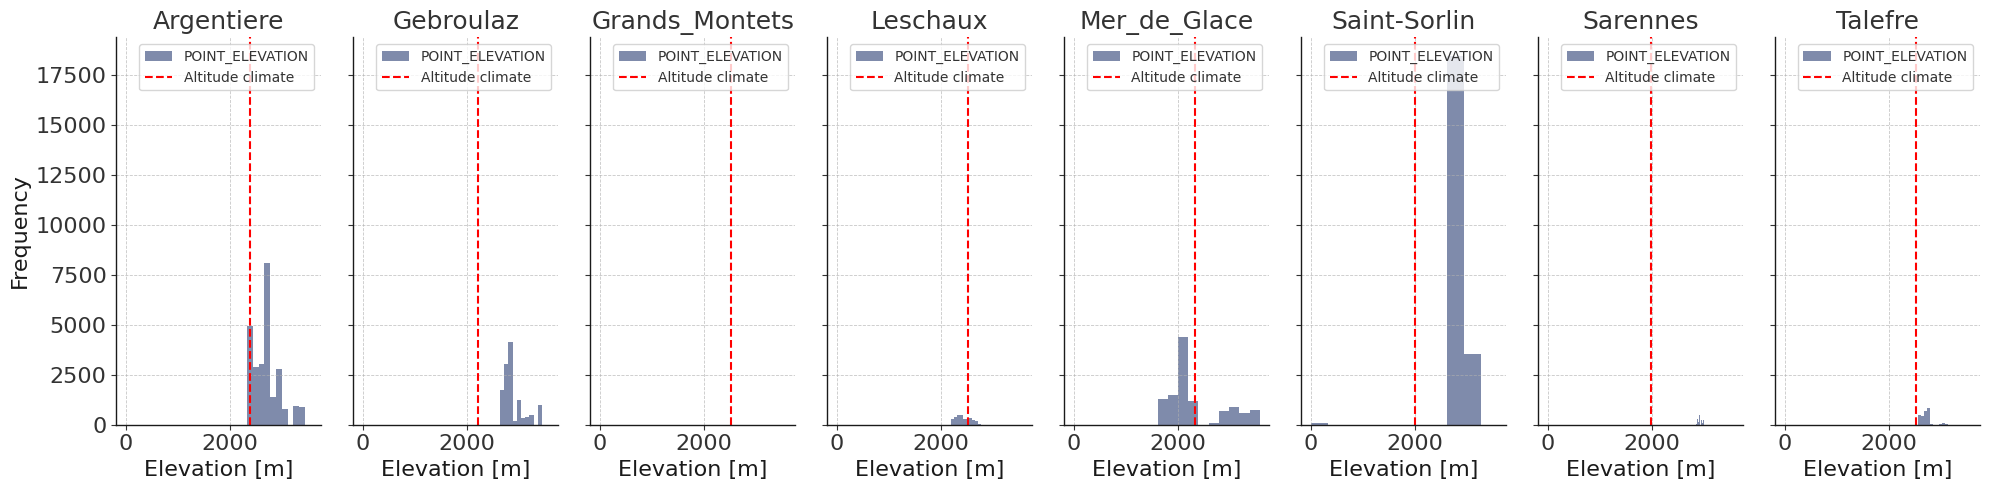

In [14]:
f, ax = plt.subplots(1,
                     len(test_glaciers),
                     figsize=(20, 5),
                     sharey='row',
                     sharex='row')

for i, test_gl in enumerate(test_glaciers):
    test_df_gl = test_set['df_X'][test_set['df_X'].GLACIER == test_gl]
    test_df_gl.POINT_ELEVATION.plot.hist(color=color_dark_blue,
                                         alpha=0.5,
                                         density=False,
                                         ax=ax[i])
    # add vertical line for altitude climate
    alt_climate = test_df_gl.ALTITUDE_CLIMATE.mean()
    ax[i].axvline(x=alt_climate,
                  color='red',
                  linestyle='--',
                  label='Altitude climate')
    ax[i].set_xlabel('Elevation [m]')
    ax[i].legend()
    ax[i].set_title(test_gl)
plt.tight_layout()

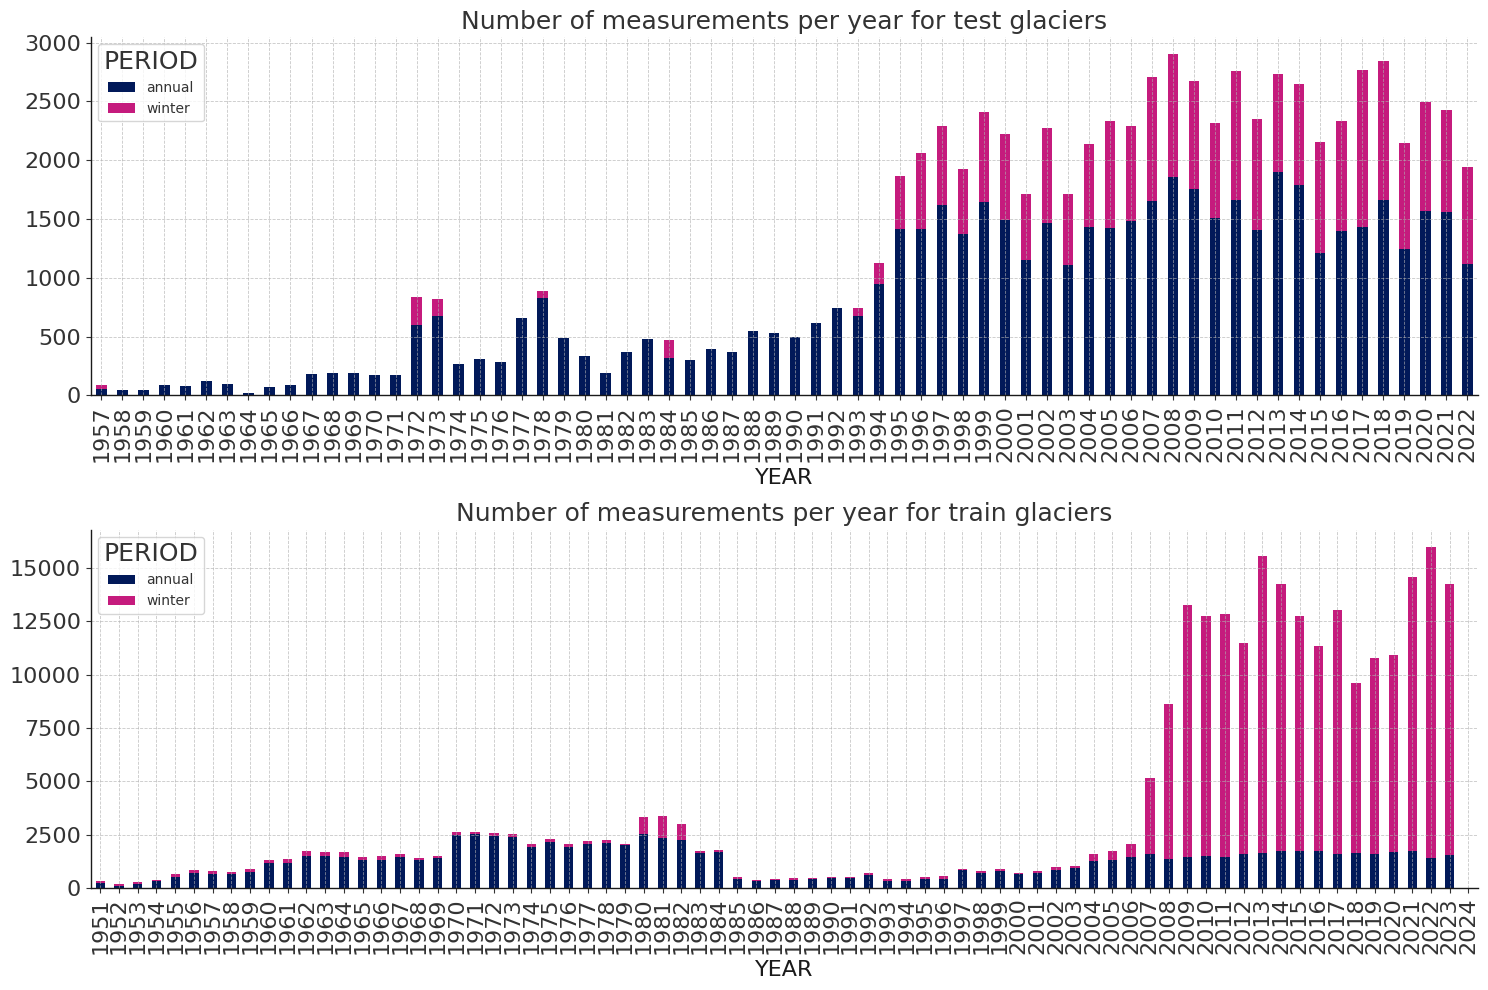

In [17]:
# Number of measurements per year:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
df_X_test.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[0])
ax[0].set_title('Number of measurements per year for test glaciers')

# Number of measurements per year:
df_X_train.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[1])
ax[1].set_title('Number of measurements per year for train glaciers')
plt.tight_layout()

## XGBoost:

In [21]:
# Grid search
# For each of the XGBoost parameter, define the grid range
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'n_estimators':
    [50, 100, 200, 300, 400, 500, 600,
     700],  # number of trees (too many = overfitting, too few = underfitting)
    'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]
}

param_init = {}
param_init['device'] = 'cuda:0'
param_init['tree_method'] = 'hist'
param_init["random_state"] = cfg.seed
param_init["n_jobs"] = cfg.numJobs

# vois_climate = [
#     't2m_corr', 'tp_corr', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10',
#     'v10'
# ]

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
]

### Grid search:

In [22]:
%%time
# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

RUN = False
if RUN:
    # Create a CustomXGBoostRegressor instance
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg, **param_init)
    custom_xgboost.randomsearch(
        parameters=param_grid,
        n_iter=45,
        splits=splits,
        features=df_X_train_subset,
        targets=train_set['y'],
    )

    # save best model
    custom_xgboost.save_model(f'CH_FR_no_summer.pkl')
else:
    # read model
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg)
    custom_xgboost.load_model(
        f'CH_FR_no_summer.pkl')

# Get best parameters and estimator
best_params = custom_xgboost.param_search.best_params_
best_estimator = custom_xgboost.param_search.best_estimator_
print("Best parameters:\n", best_params)
print("Best score:\n", custom_xgboost.param_search.best_score_)

# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

# Make predictions on test
features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)

# Calculate scores
score = best_estimator_cpu.score(test_set['df_X'][all_columns],
                                 test_set['y'])  # negative
print('Overall score:', np.abs(score))

Shape of training dataset: (281110, 27)
Shape of testing dataset: (79311, 27)
Running with features: ['ELEVATION_DIFFERENCE', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'aspect', 'slope', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v']
Best parameters:
 {'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.01}
Best score:
 -0.19993656704889418
Shape of the test: (79311, 15)
Overall score: 1.8735717529429552
CPU times: user 7.08 s, sys: 203 ms, total: 7.28 s
Wall time: 450 ms


In [ ]:
# visualiseValPreds(best_estimator, splits, train_set, feature_columns)

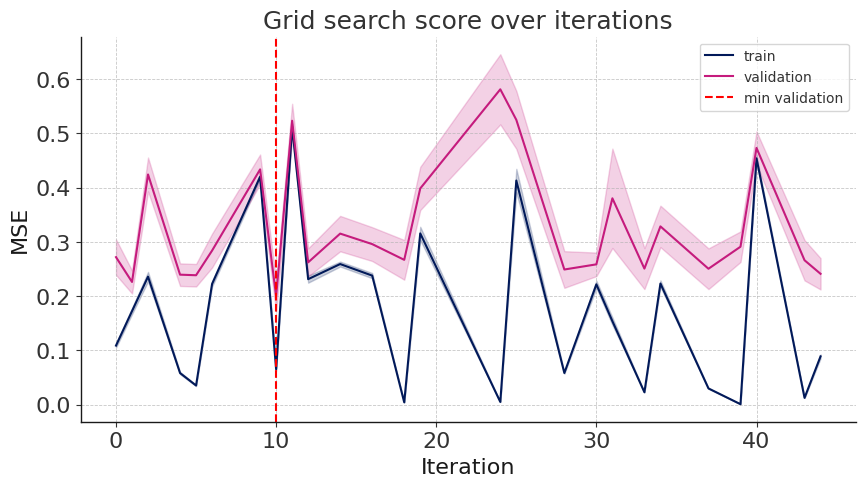

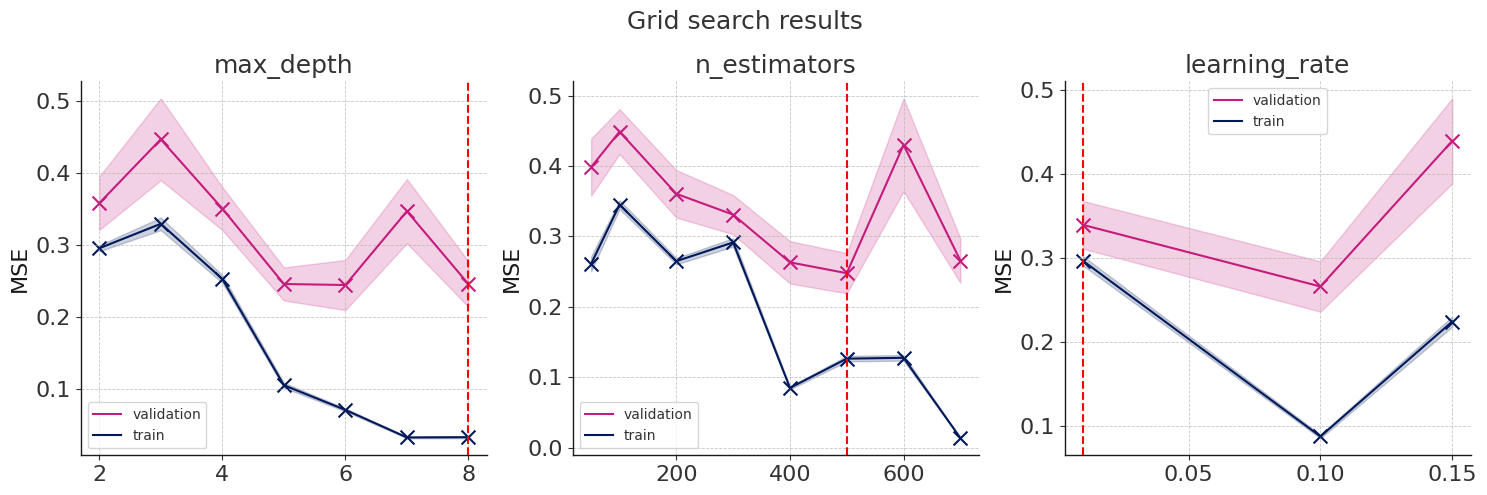

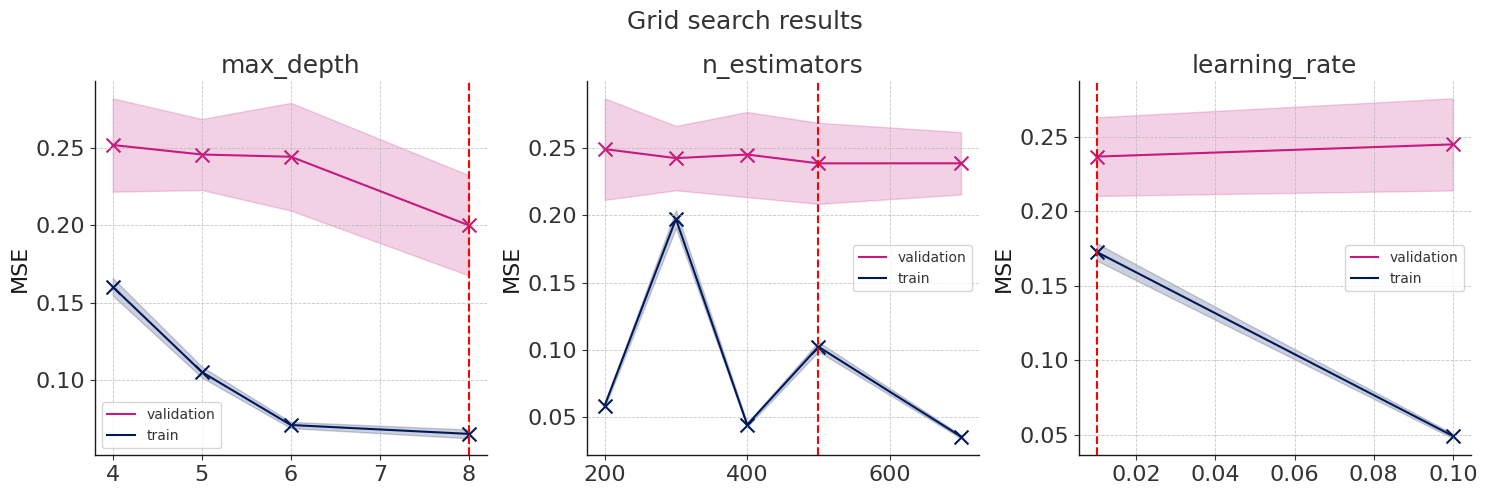

In [23]:
plotGridSearchScore(cv_results_=custom_xgboost.param_search.cv_results_,
                    lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss,
                     N=10)

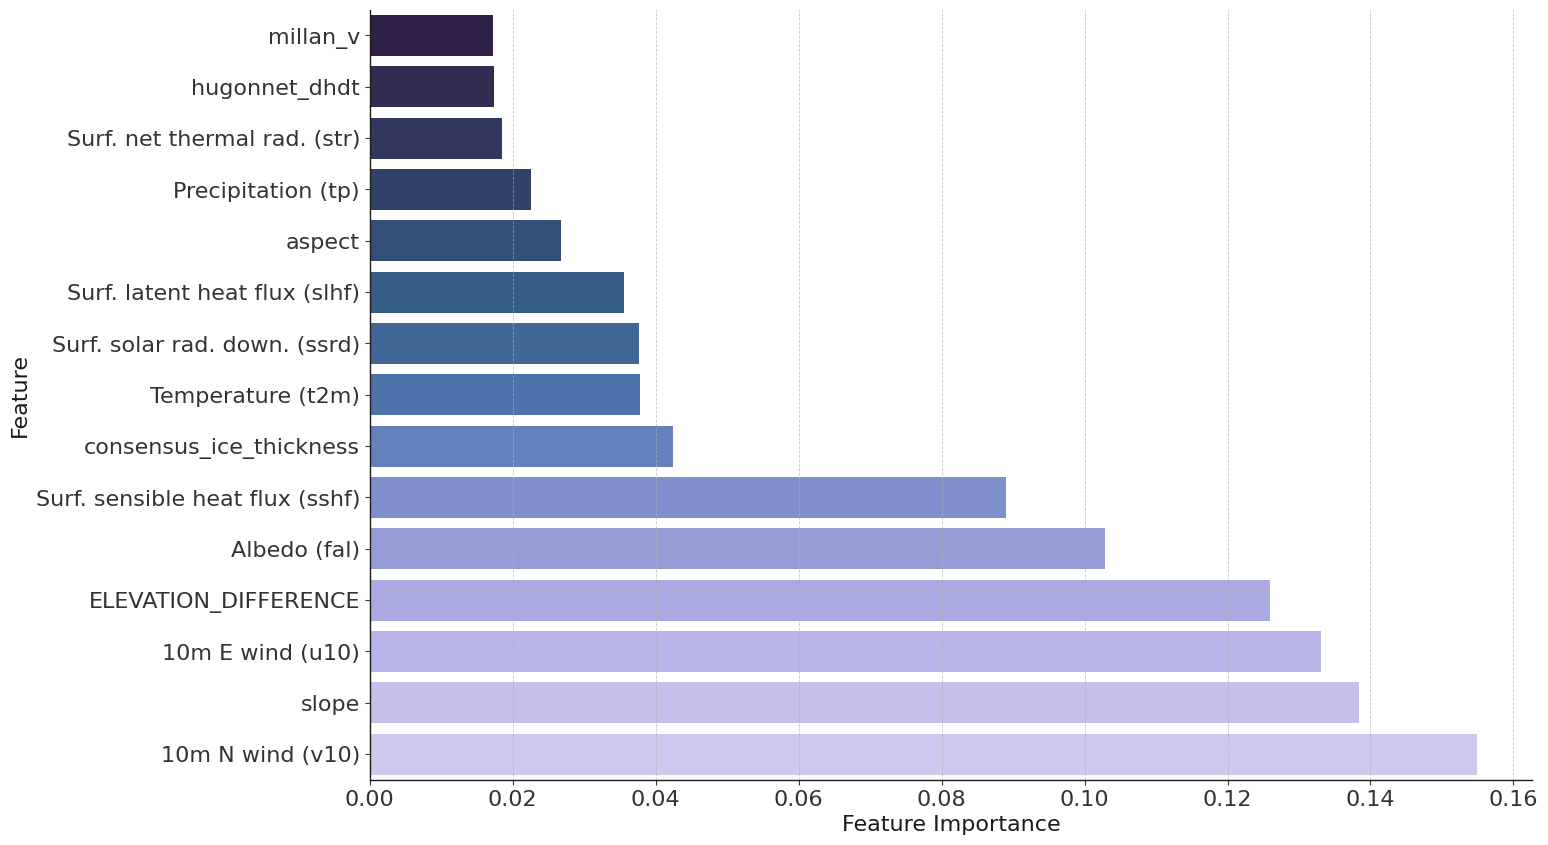

In [24]:
FIPlot(best_estimator, feature_columns, vois_climate)

#### Predictions of best parameters:

Shape of the test: (79311, 15)
{'Argentiere': '#a6cee3', 'Gebroulaz': '#1f78b4', 'Grands_Montets': '#b2df8a', 'Leschaux': '#33a02c', 'Mer_de_Glace': '#fb9a99', 'Saint-Sorlin': '#e31a1c', 'Sarennes': '#fdbf6f', 'Talefre': '#ff7f00'}


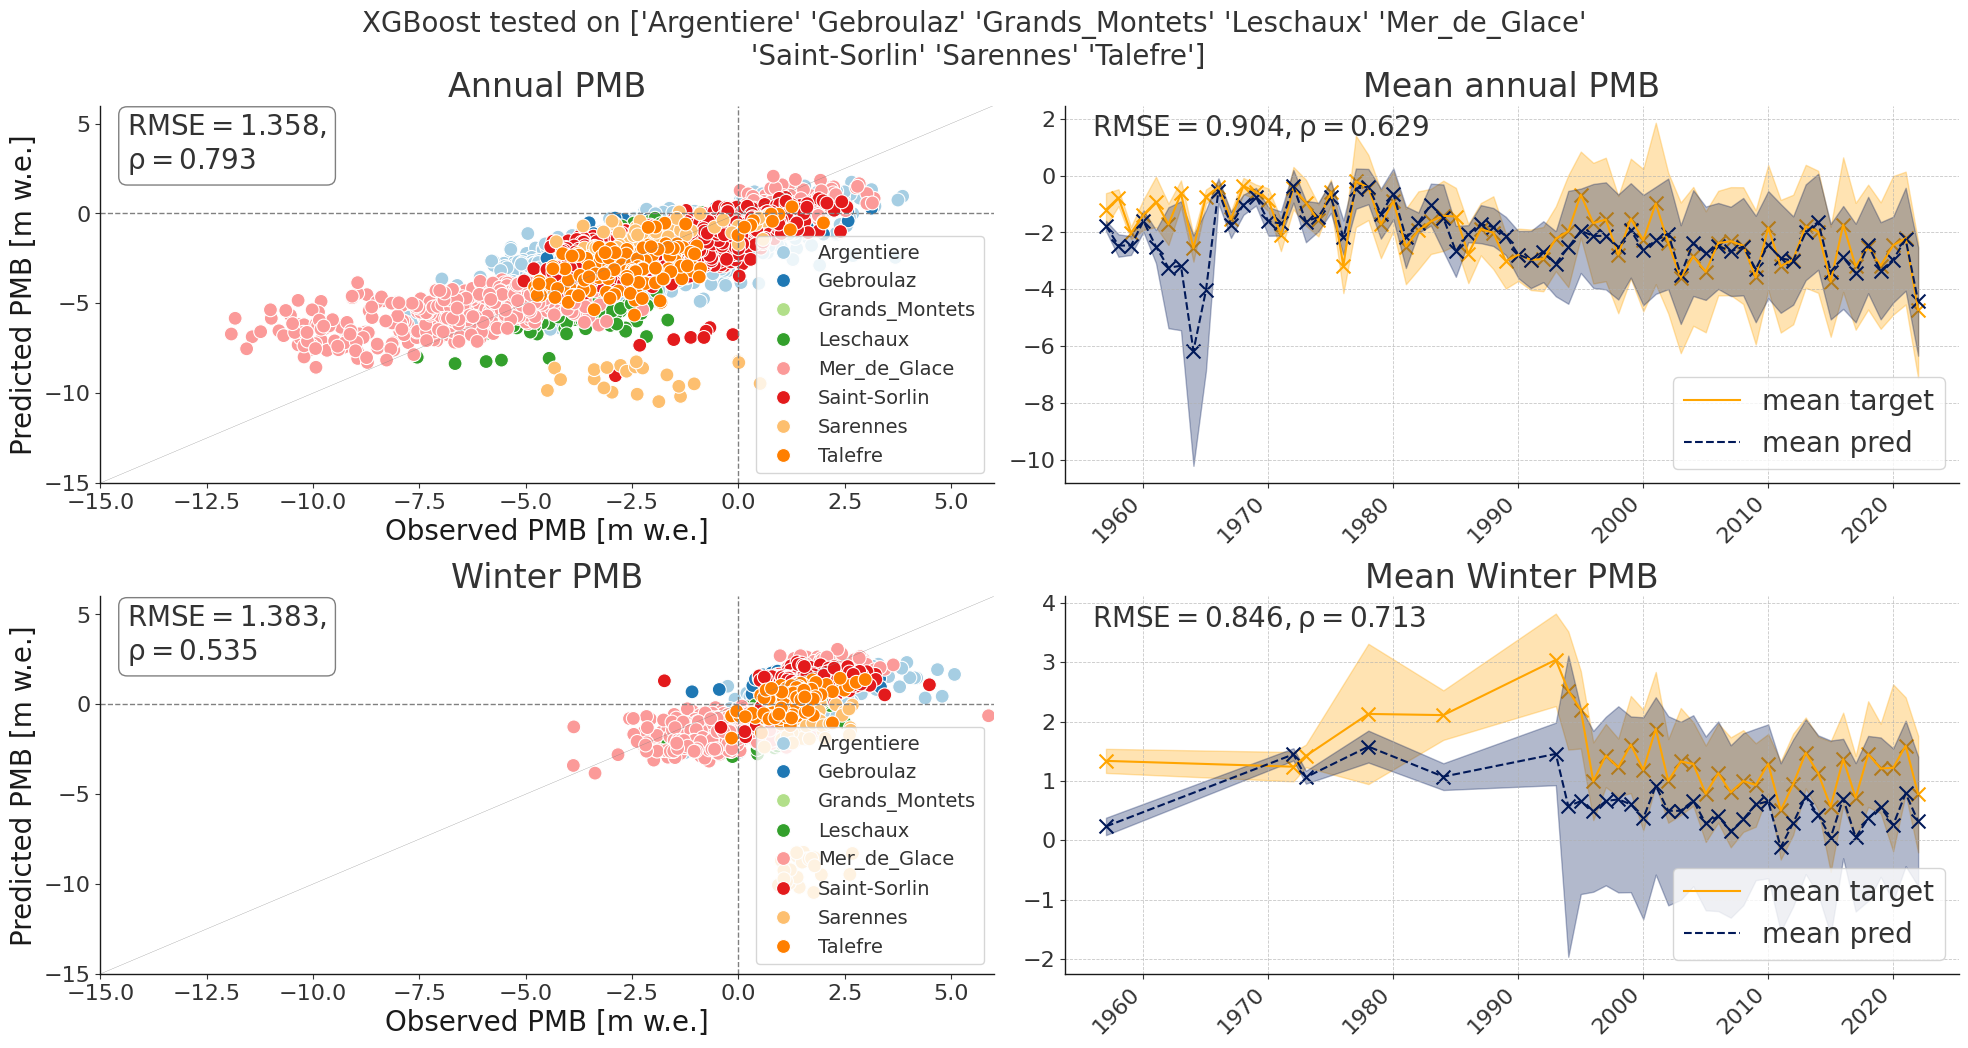

In [25]:
# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)
grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu)
plt.suptitle(f'XGBoost tested on {test_glaciers}', fontsize=20)
plt.tight_layout()

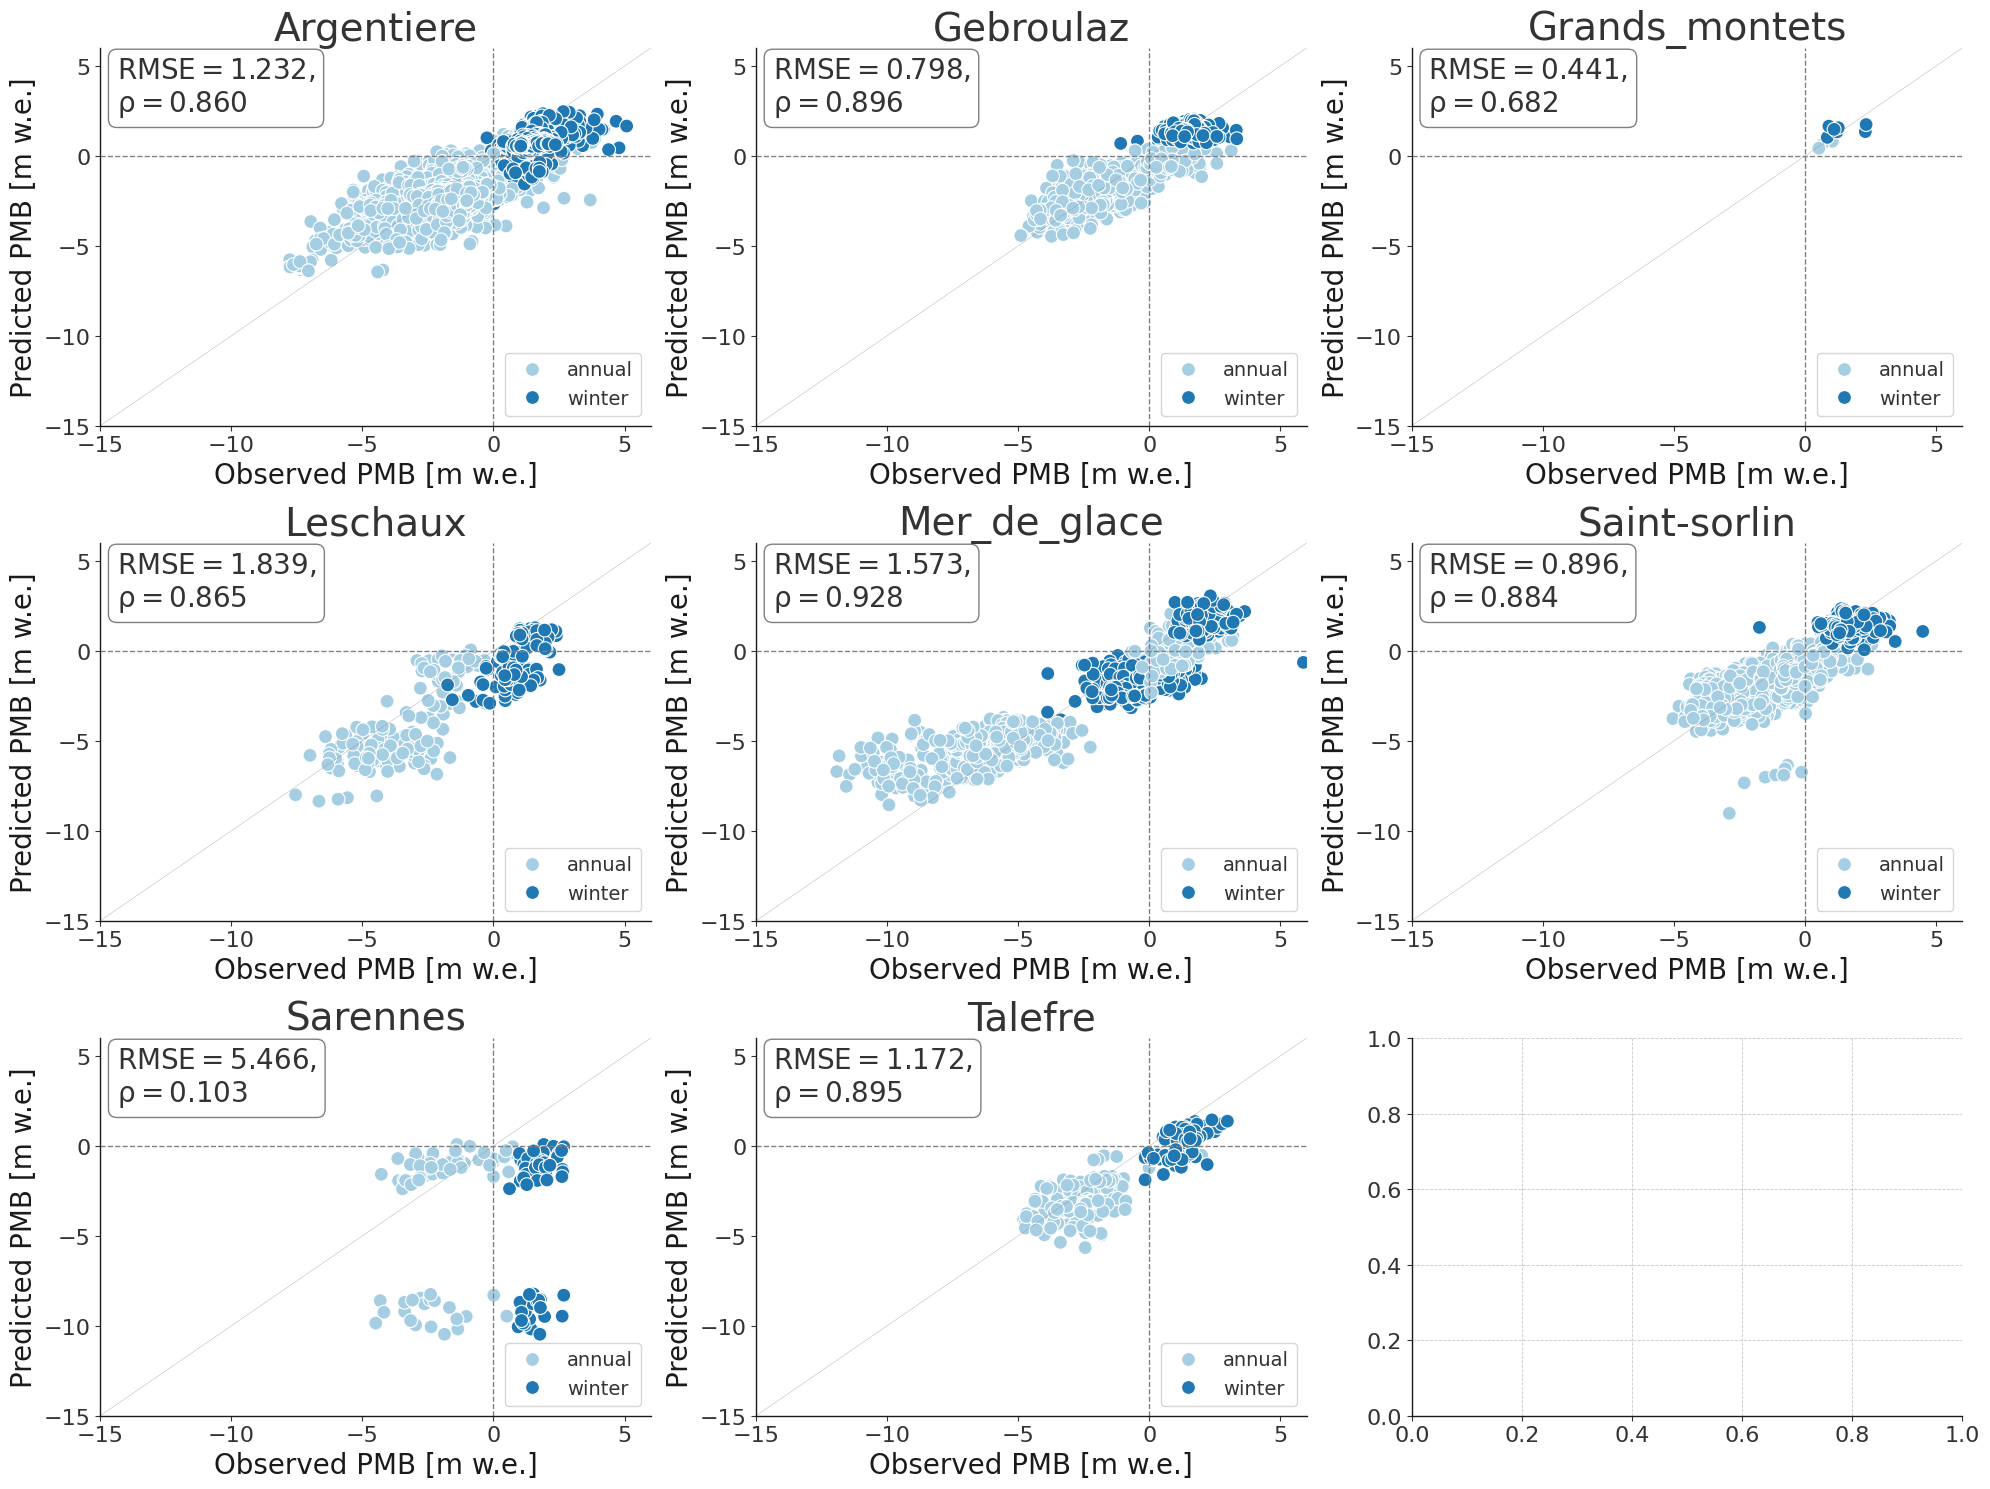

In [26]:
PlotIndividualGlacierPredVsTruth(grouped_ids, figsize=(20, 15))

Text(0.5, 1.02, 'Feature Distributions: Worst Predictions per Glacier')

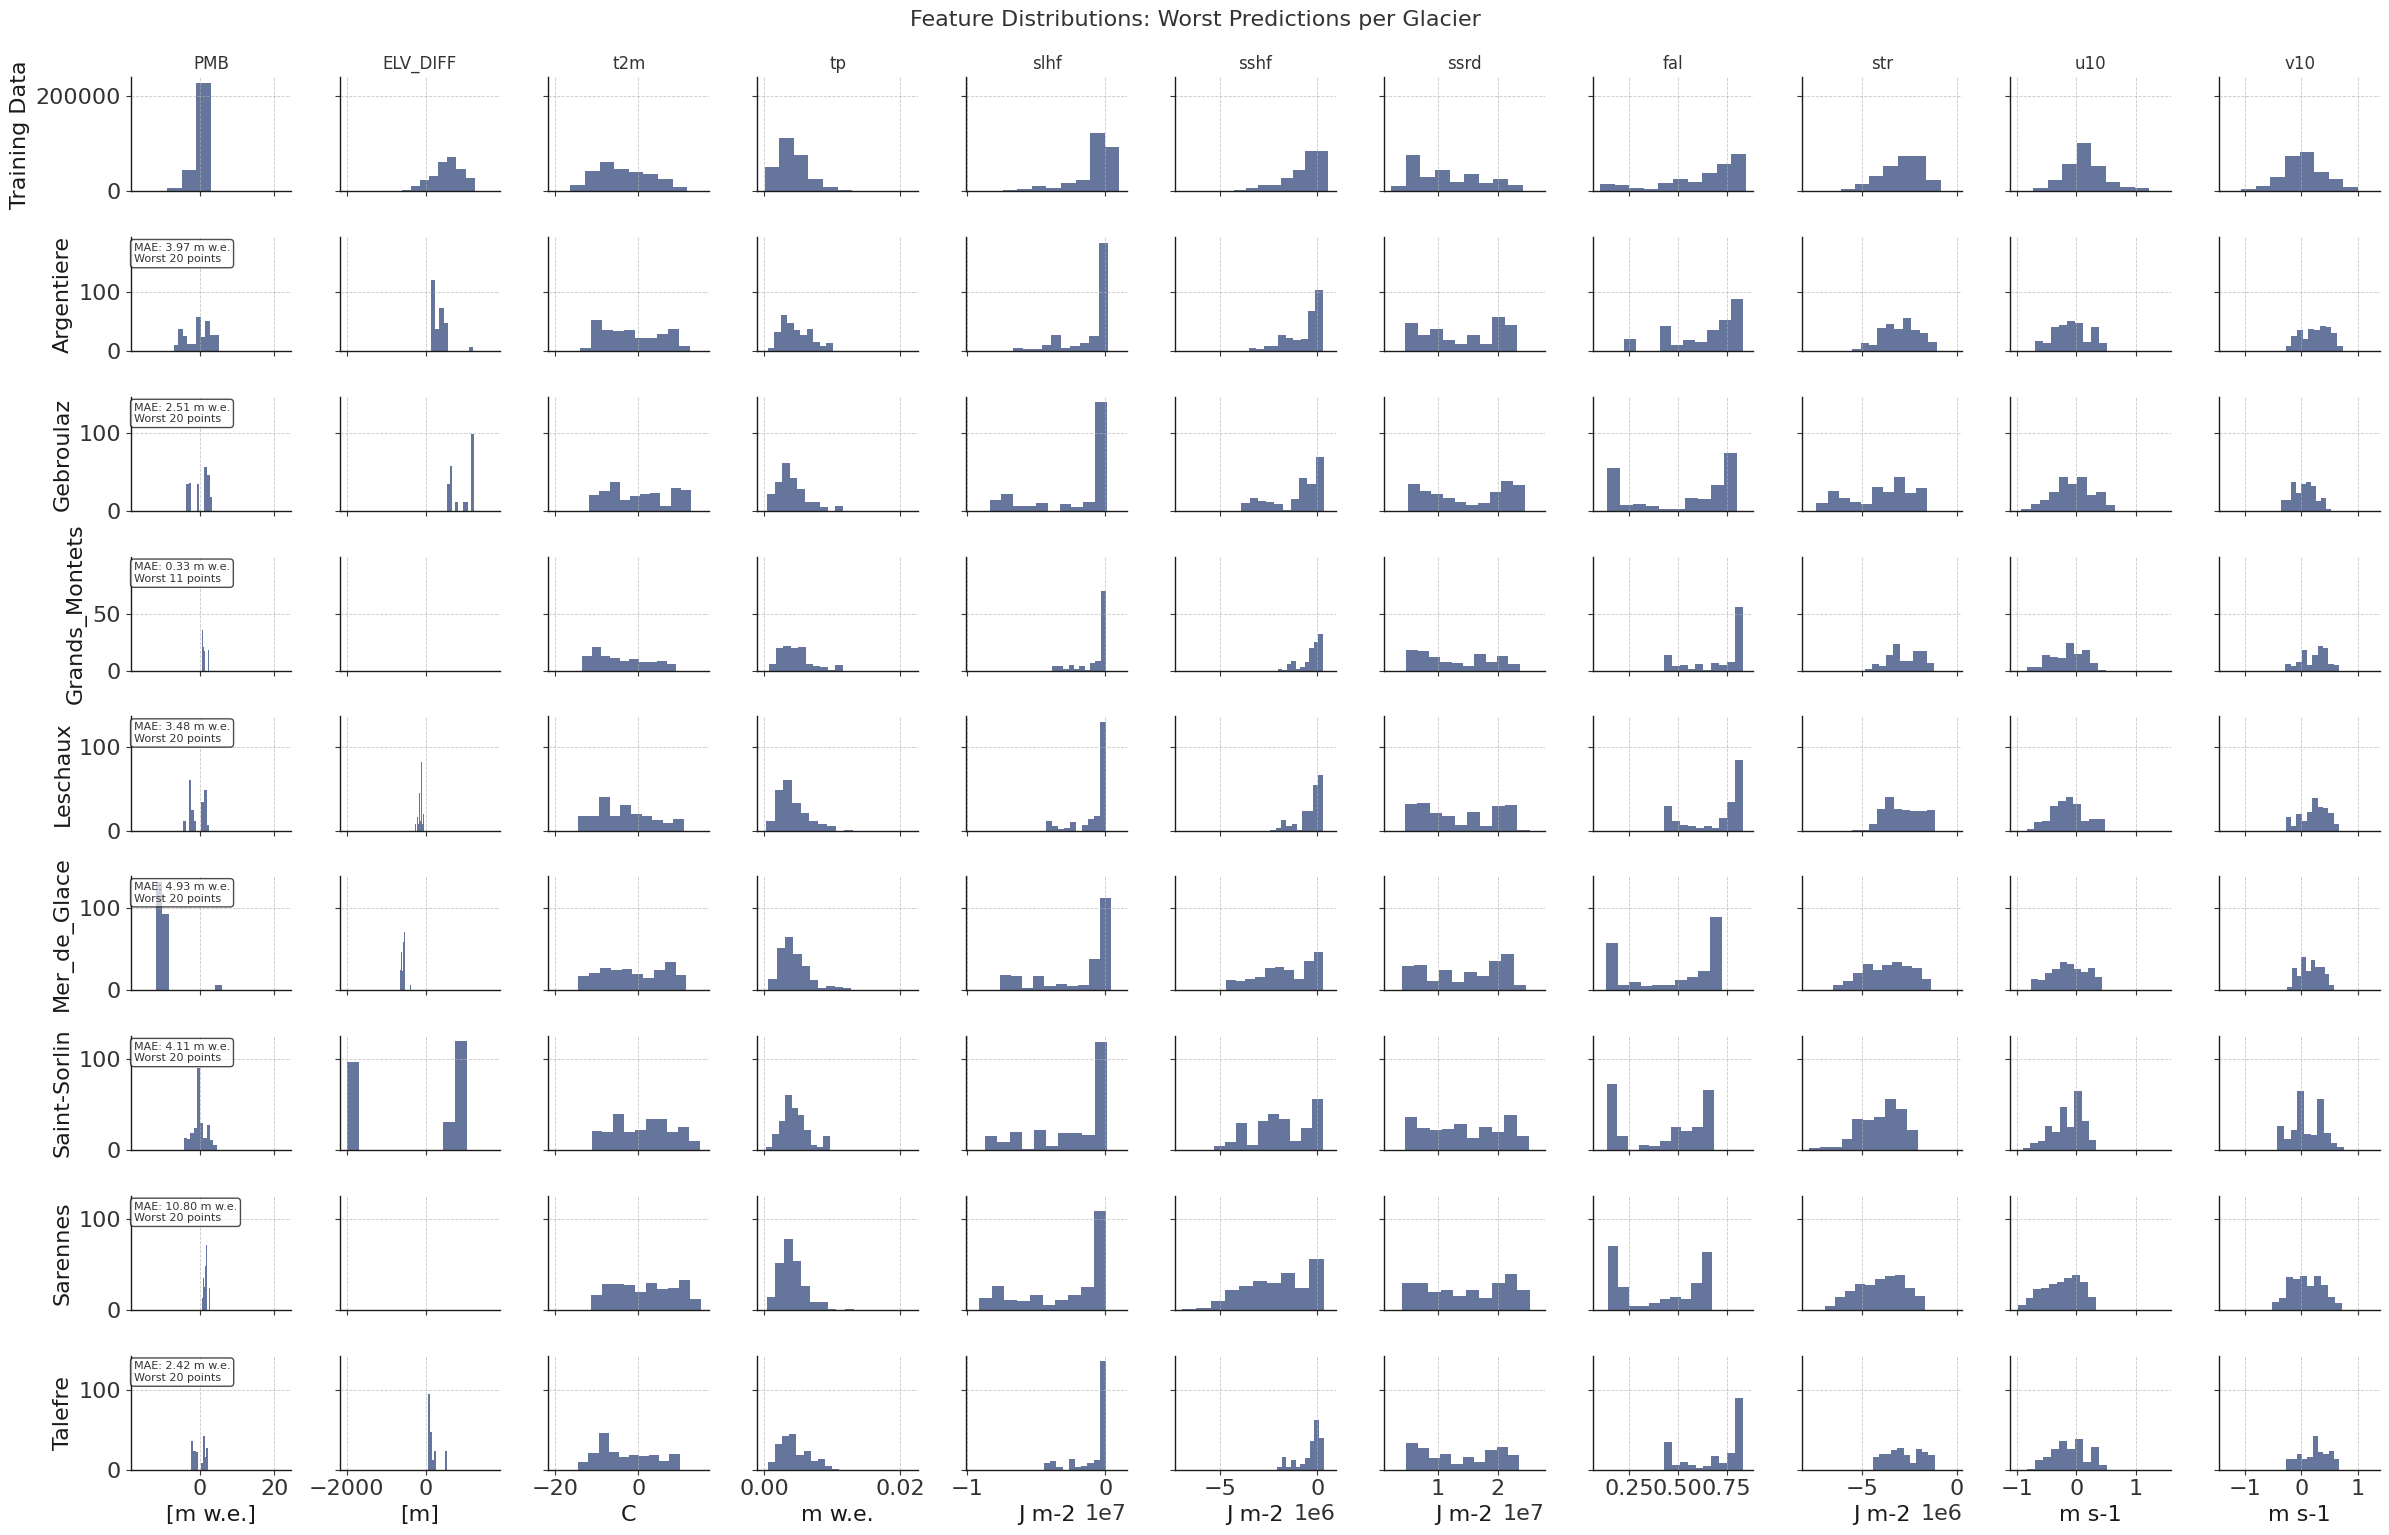

In [71]:
# First, identify the worst predictions for each glacier
def get_worst_n_predictions(df, n=20):
    """Get the n worst predictions for each glacier based on absolute error."""
    # Calculate absolute error
    df['abs_error'] = abs(df['pred'] - df['target'])
    
    # Group by GLACIER and get the n points with the highest error
    worst_points = df.groupby('GLACIER').apply(
        lambda x: x.nlargest(min(n, len(x)), 'abs_error')
    ).reset_index(drop=True)
    
    return worst_points

# Get the worst 20 predictions for each glacier
worst_predictions = get_worst_n_predictions(grouped_ids, n=20)

# Loop through each glacier and create the plot
test_glaciers = worst_predictions['GLACIER'].unique()
n_rows = len(test_glaciers) + 1 
f, ax = plt.subplots(n_rows,
                     len(vois_climate) + 2,
                     figsize=(24, 15),
                     sharey='row',
                     sharex='col')

# Plot the training data in the first row
train_df = train_set['df_X']
train_df['POINT_BALANCE'].plot.hist(ax=ax[0, 0],
                                   color=color_xgb,
                                   alpha=0.6,
                                   density=False)
ax[0, 0].set_title('PMB', fontsize=12)
ax[0, 0].set_ylabel('Training Data')
ax[0, 0].set_xlabel('[m w.e.]')

train_df['ELEVATION_DIFFERENCE'].plot.hist(ax=ax[0, 1],
                                         color=color_xgb,
                                         alpha=0.6,
                                         density=False)
ax[0, 1].set_title('ELV_DIFF', fontsize=12)
ax[0, 1].set_xlabel('[m]')

for j, voi_clim in enumerate(vois_climate):
    ax[0, 2 + j].set_title(voi_clim, fontsize=12)
    train_df[voi_clim].plot.hist(ax=ax[0, 2 + j],
                               color=color_xgb,
                               alpha=0.6,
                               density=False)
    ax[0, 2 + j].set_xlabel(vois_units[voi_clim])

# Plot each glacier's worst predictions
for i, test_gl in enumerate(test_glaciers):
    row_idx = i + 1
    
    # Get the worst point IDs for this glacier
    worst_gl_points = worst_predictions[worst_predictions['GLACIER'] == test_gl]['POINT_ID'].values
    
    # Filter test_set data to only include these worst points
    test_df_gl = test_set['df_X'][test_set['df_X']['POINT_ID'].isin(worst_gl_points)]
    
    # If we have data for this glacier's worst points, plot it
    if len(test_df_gl) > 0:
        test_df_gl['POINT_BALANCE'].plot.hist(ax=ax[row_idx, 0],
                                             color=color_dark_blue,
                                             alpha=0.6,
                                             density=False)
        
        # Calculate mean error but add it to a text box instead of cluttering the y-label
        errors = worst_predictions[worst_predictions['GLACIER'] == test_gl]['abs_error']
        mean_error = errors.mean()
        
        # Just use glacier name as y-label
        ax[row_idx, 0].set_ylabel(test_gl)
        
        # Add error info as text annotation on the first subplot
        ax[row_idx, 0].text(0.02, 0.95, 
                          f"MAE: {mean_error:.2f} m w.e.\nWorst {len(worst_gl_points)} points",
                          transform=ax[row_idx, 0].transAxes,
                          fontsize=8,
                          verticalalignment='top',
                          bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        
        ax[row_idx, 0].set_xlabel('[m w.e.]')
        
        test_df_gl['ELEVATION_DIFFERENCE'].plot.hist(ax=ax[row_idx, 1],
                                                    color=color_dark_blue,
                                                    alpha=0.6,
                                                    density=False)
        ax[row_idx, 1].set_xlabel('[m]')

        for j, voi_clim in enumerate(vois_climate):
            test_df_gl[voi_clim].plot.hist(ax=ax[row_idx, 2 + j],
                                          color=color_dark_blue,
                                          alpha=0.6,
                                          density=False)
            ax[row_idx, 2 + j].set_xlabel(vois_units[voi_clim])
    else:
        # If no data found for this glacier, add a text message
        ax[row_idx, 0].text(0.5, 0.5, "No data found for worst predictions", 
                          ha='center', va='center', transform=ax[row_idx, 0].transAxes)
        ax[row_idx, 0].set_ylabel(test_gl)

# Improved layout with more width
plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.3)  # Added wspace for more horizontal spacing between subplots
plt.suptitle('Feature Distributions: Worst Predictions per Glacier', 
            fontsize=16, y=1.02)

In [73]:
def show_worst_prediction_details(grouped_ids, test_set, n=20):
    """
    Shows the details of the worst n predictions for each glacier.
    
    Parameters:
    -----------
    grouped_ids : DataFrame
        DataFrame with columns 'GLACIER', 'POINT_ID', 'pred', 'target'
    test_set : dict
        Dictionary containing test data with 'df_X' key
    n : int
        Number of worst predictions to show per glacier
    """
    # Get the worst predictions
    worst_predictions = get_worst_n_predictions(grouped_ids, n=n)
    
    # Group by glacier
    glaciers = worst_predictions['GLACIER'].unique()
    
    # Display data for each glacier
    for glacier in glaciers:
        print(f"\n{'='*70}")
        print(f"Worst {n} predictions for glacier: {glacier}")
        print(f"{'='*70}")
        
        # Get point IDs for this glacier's worst predictions
        point_ids = worst_predictions[worst_predictions['GLACIER'] == glacier]['POINT_ID'].values
        
        # Get rows from test_set for these point IDs
        glacier_data = test_set['df_X'][test_set['df_X']['POINT_ID'].isin(point_ids)]
        
        # Display with all rows
        with pd.option_context('display.max_rows', None):
            display(glacier_data)

# After running your model and getting grouped_ids
show_worst_prediction_details(grouped_ids, test_set, n=20)


Worst 20 predictions for glacier: Argentiere


YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
2911   1994   7.033463  45.926991           3.69       2524.444781   
2912   1994   7.033463  45.926991           3.69       2524.444781   
2913   1994   7.033463  45.926991           3.69       2524.444781   
2914   1994   7.033463  45.926991           3.69       2524.444781   
2915   1994   7.033463  45.926991           3.69       2524.444781   
2916   1994   7.033463  45.926991           3.69       2524.444781   
2917   1994   7.033463  45.926991           3.69       2524.444781   
2918   1994   7.033463  45.926991           3.69       2524.444781   
2919   1994   7.033463  45.926991           3.69       2524.444781   
2920   1994   7.033463  45.926991           3.69       2524.444781   
2921   1994   7.033463  45.926991           3.69       2524.444781   
2922   1994   7.033463  45.926991           3.69       2524.444781   
2923   1994   7.033463  45.926991           3.69       2524.444781   
2924   1994   7.033463  45.926991           3.69       2524.444781   
2925   1994   7.027843  45.930740           2.69       2524.444781   
2926   1994   7.027843  45.930740           2.69       2524.444781   
2927   1994   7.027843  45.930740           2.69       2524.444781   
2928   1994   7.027843  45.930740           2.69       2524.444781   
2929   1994   7.027843  45.930740           2.69       2524.444781   
2930   1994   7.027843  45.930740           2.69       2524.444781   
2931   1994   7.027843  45.930740           2.69       2524.444781   
2932   1994   7.027843  45.930740           2.69       2524.444781   
2933   1994   7.027843  45.930740           2.69       2524.444781   
2934   1994   7.027843  45.930740           2.69       2524.444781   
2935   1994   7.027843  45.930740           2.69       2524.444781   
2936   1994   7.027843  45.930740           2.69       2524.444781   
2937   1994   7.027843  45.930740           2.69       2524.444781   
2938   1994   7.027843  45.930740           2.69       2524.444781   
2939   1994   7.020463  45.932039           1.91       2524.444781   
2940   1994   7.020463  45.932039           1.91       2524.444781   
2941   1994   7.020463  45.932039           1.91       2524.444781   
2942   1994   7.020463  45.932039           1.91       2524.444781   
2943   1994   7.020463  45.932039           1.91       2524.444781   
2944   1994   7.020463  45.932039           1.91       2524.444781   
2945   1994   7.020463  45.932039           1.91       2524.444781   
2946   1994   7.020463  45.932039           1.91       2524.444781   
2947   1994   7.020463  45.932039           1.91       2524.444781   
2948   1994   7.020463  45.932039           1.91       2524.444781   
2949   1994   7.020463  45.932039           1.91       2524.444781   
2950   1994   7.020463  45.932039           1.91       2524.444781   
2951   1994   7.020463  45.932039           1.91       2524.444781   
2952   1994   7.020463  45.932039           1.91       2524.444781   
3549   2001   7.033466  45.927027           2.30       2524.444781   
3550   2001   7.033466  45.927027           2.30       2524.444781   
3551   2001   7.033466  45.927027           2.30       2524.444781   
3552   2001   7.033466  45.927027           2.30       2524.444781   
3553   2001   7.033466  45.927027           2.30       2524.444781   
3554   2001   7.033466  45.927027           2.30       2524.444781   
3555   2001   7.033466  45.927027           2.30       2524.444781   
3556   2001   7.033466  45.927027           2.30       2524.444781   
3557   2001   7.033466  45.927027           2.30       2524.444781   
3558   2001   7.033466  45.927027           2.30       2524.444781   
3559   2001   7.033466  45.927027           2.30       2524.444781   
3560   2001   7.033466  45.927027           2.30       2524.444781   
3573   2001   7.026717  45.927993           2.30       2524.444781   
3574   2001   7.026717  45.927993           2.30       2524.444781   
3575   2001   7.0


Worst 20 predictions for glacier: Gebroulaz


YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
29795  1993   6.625580  45.304800          -0.18       2203.813034   
29796  1993   6.625580  45.304800          -0.18       2203.813034   
29797  1993   6.625580  45.304800          -0.18       2203.813034   
29798  1993   6.625580  45.304800          -0.18       2203.813034   
29799  1993   6.625580  45.304800          -0.18       2203.813034   
29800  1993   6.625580  45.304800          -0.18       2203.813034   
29801  1993   6.625580  45.304800          -0.18       2203.813034   
29802  1993   6.625580  45.304800          -0.18       2203.813034   
29803  1993   6.625580  45.304800          -0.18       2203.813034   
29804  1993   6.625580  45.304800          -0.18       2203.813034   
29805  1993   6.625580  45.304800          -0.18       2203.813034   
29806  1993   6.626294  45.301194          -0.45       2203.813034   
29807  1993   6.626294  45.301194          -0.45       2203.813034   
29808  1993   6.626294  45.301194          -0.45       2203.813034   
29809  1993   6.626294  45.301194          -0.45       2203.813034   
29810  1993   6.626294  45.301194          -0.45       2203.813034   
29811  1993   6.626294  45.301194          -0.45       2203.813034   
29812  1993   6.626294  45.301194          -0.45       2203.813034   
29813  1993   6.626294  45.301194          -0.45       2203.813034   
29814  1993   6.626294  45.301194          -0.45       2203.813034   
29815  1993   6.626294  45.301194          -0.45       2203.813034   
29816  1993   6.626294  45.301194          -0.45       2203.813034   
30392  1998   6.630090  45.298752          -3.51       2203.813034   
30393  1998   6.630090  45.298752          -3.51       2203.813034   
30394  1998   6.630090  45.298752          -3.51       2203.813034   
30395  1998   6.630090  45.298752          -3.51       2203.813034   
30396  1998   6.630090  45.298752          -3.51       2203.813034   
30397  1998   6.630090  45.298752          -3.51       2203.813034   
30398  1998   6.630090  45.298752          -3.51       2203.813034   
30399  1998   6.630090  45.298752          -3.51       2203.813034   
30400  1998   6.630090  45.298752          -3.51       2203.813034   
30401  1998   6.630090  45.298752          -3.51       2203.813034   
35135  2017   6.624595  45.298229          -0.31       2203.813034   
35136  2017   6.624595  45.298229          -0.31       2203.813034   
35137  2017   6.624595  45.298229          -0.31       2203.813034   
35138  2017   6.624595  45.298229          -0.31       2203.813034   
35139  2017   6.624595  45.298229          -0.31       2203.813034   
35140  2017   6.624595  45.298229          -0.31       2203.813034   
35141  2017   6.624595  45.298229          -0.31       2203.813034   
35142  2017   6.624595  45.298229          -0.31       2203.813034   
35143  2017   6.624595  45.298229          -0.31       2203.813034   
35144  2017   6.624595  45.298229          -0.31       2203.813034   
35145  2017   6.624595  45.298229          -0.31       2203.813034   
35146  2017   6.624595  45.298229          -0.31       2203.813034   
35243  2018   6.628085  45.293491          -2.59       2203.813034   
35244  2018   6.628085  45.293491          -2.59       2203.813034   
35245  2018   6.628085  45.293491          -2.59       2203.813034   
35246  2018   6.628085  45.293491          -2.59       2203.813034   
35247  2018   6.628085  45.293491          -2.59       2203.813034   
35248  2018   6.628085  45.293491          -2.59       2203.813034   
35249  2018   6.628085  45.293491          -2.59       2203.813034   
35250  2018   6.628085  45.293491          -2.59       2203.813034   
35251  2018   6.628085  45.293491          -2.59       2203.813034   
35252  2018   6.628085  45.293491          -2.59       2203.813034   
35253  2018   6.628085  45.293491          -2.59       2203.813034   
35254  2018   6.628085  45.293491          -2.59       2203.813034   
35255  2018   6.6


Worst 20 predictions for glacier: Grands_Montets


YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
44597  1995   6.960218  45.946697           1.04       2524.444781   
44598  1995   6.960218  45.946697           1.04       2524.444781   
44599  1995   6.960218  45.946697           1.04       2524.444781   
44600  1995   6.960218  45.946697           1.04       2524.444781   
44601  1995   6.960218  45.946697           1.04       2524.444781   
44602  1995   6.960218  45.946697           1.04       2524.444781   
44603  1995   6.960218  45.946697           1.04       2524.444781   
44604  1995   6.960218  45.946697           1.04       2524.444781   
44605  1995   6.960218  45.946697           1.04       2524.444781   
44606  1995   6.960218  45.946697           1.04       2524.444781   
44607  1995   6.960218  45.946697           1.04       2524.444781   
44608  1995   6.960218  45.946697           1.04       2524.444781   
44609  1995   6.960218  45.946697           1.04       2524.444781   
44610  1997   6.960218  45.946697           0.65       2524.444781   
44611  1997   6.960218  45.946697           0.65       2524.444781   
44612  1997   6.960218  45.946697           0.65       2524.444781   
44613  1997   6.960218  45.946697           0.65       2524.444781   
44614  1997   6.960218  45.946697           0.65       2524.444781   
44615  1997   6.960218  45.946697           0.65       2524.444781   
44616  1997   6.960218  45.946697           0.65       2524.444781   
44617  1997   6.960218  45.946697           0.65       2524.444781   
44618  1997   6.960218  45.946697           0.65       2524.444781   
44619  1997   6.960218  45.946697           0.65       2524.444781   
44620  1997   6.960218  45.946697           0.65       2524.444781   
44621  1997   6.960218  45.946697           0.65       2524.444781   
44622  1999   6.960071  45.946794           0.53       2524.444781   
44623  1999   6.960071  45.946794           0.53       2524.444781   
44624  1999   6.960071  45.946794           0.53       2524.444781   
44625  1999   6.960071  45.946794           0.53       2524.444781   
44626  1999   6.960071  45.946794           0.53       2524.444781   
44627  1999   6.960071  45.946794           0.53       2524.444781   
44628  1999   6.960071  45.946794           0.53       2524.444781   
44629  1999   6.960071  45.946794           0.53       2524.444781   
44630  1999   6.960071  45.946794           0.53       2524.444781   
44631  1999   6.960071  45.946794           0.53       2524.444781   
44632  1999   6.960071  45.946794           0.53       2524.444781   
44633  1999   6.960071  45.946794           0.53       2524.444781   
44634  2000   6.960071  45.946794           0.53       2524.444781   
44635  2000   6.960071  45.946794           0.53       2524.444781   
44636  2000   6.960071  45.946794           0.53       2524.444781   
44637  2000   6.960071  45.946794           0.53       2524.444781   
44638  2000   6.960071  45.946794           0.53       2524.444781   
44639  2000   6.960071  45.946794           0.53       2524.444781   
44640  2000   6.960071  45.946794           0.53       2524.444781   
44641  2000   6.960071  45.946794           0.53       2524.444781   
44642  2000   6.960071  45.946794           0.53       2524.444781   
44643  2000   6.960071  45.946794           0.53       2524.444781   
44644  2000   6.960071  45.946794           0.53       2524.444781   
44645  2000   6.960071  45.946794           0.53       2524.444781   
44657  1993   6.960071  45.946794           2.30       2524.444781   
44658  1993   6.960071  45.946794           2.30       2524.444781   
44659  1993   6.960071  45.946794           2.30       2524.444781   
44660  1993   6.960071  45.946794           2.30       2524.444781   
44661  1993   6.960071  45.946794           2.30       2524.444781   
44662  1993   6.960071  45.946794           2.30       2524.444781   
44663  1993   6.960071  45.946794           2.30       2524.444781   
44664  1993   6.9


Worst 20 predictions for glacier: Leschaux


YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
45336  2009   6.981797  45.888611          -3.01       2524.444781   
45337  2009   6.981797  45.888611          -3.01       2524.444781   
45338  2009   6.981797  45.888611          -3.01       2524.444781   
45339  2009   6.981797  45.888611          -3.01       2524.444781   
45340  2009   6.981797  45.888611          -3.01       2524.444781   
45341  2009   6.981797  45.888611          -3.01       2524.444781   
45342  2009   6.981797  45.888611          -3.01       2524.444781   
45343  2009   6.981797  45.888611          -3.01       2524.444781   
45344  2009   6.981797  45.888611          -3.01       2524.444781   
45345  2009   6.981797  45.888611          -3.01       2524.444781   
45346  2009   6.981797  45.888611          -3.01       2524.444781   
45347  2009   6.981797  45.888611          -3.01       2524.444781   
45348  2009   6.981797  45.888611          -3.01       2524.444781   
45478  2010   6.981515  45.889006          -1.66       2524.444781   
45479  2010   6.981515  45.889006          -1.66       2524.444781   
45480  2010   6.981515  45.889006          -1.66       2524.444781   
45481  2010   6.981515  45.889006          -1.66       2524.444781   
45482  2010   6.981515  45.889006          -1.66       2524.444781   
45483  2010   6.981515  45.889006          -1.66       2524.444781   
45484  2010   6.981515  45.889006          -1.66       2524.444781   
45485  2010   6.981515  45.889006          -1.66       2524.444781   
45486  2010   6.981515  45.889006          -1.66       2524.444781   
45487  2010   6.981515  45.889006          -1.66       2524.444781   
45488  2010   6.981515  45.889006          -1.66       2524.444781   
45489  2010   6.981515  45.889006          -1.66       2524.444781   
45502  2010   6.982024  45.888628          -2.39       2524.444781   
45503  2010   6.982024  45.888628          -2.39       2524.444781   
45504  2010   6.982024  45.888628          -2.39       2524.444781   
45505  2010   6.982024  45.888628          -2.39       2524.444781   
45506  2010   6.982024  45.888628          -2.39       2524.444781   
45507  2010   6.982024  45.888628          -2.39       2524.444781   
45508  2010   6.982024  45.888628          -2.39       2524.444781   
45509  2010   6.982024  45.888628          -2.39       2524.444781   
45510  2010   6.982024  45.888628          -2.39       2524.444781   
45511  2010   6.982024  45.888628          -2.39       2524.444781   
45512  2010   6.982024  45.888628          -2.39       2524.444781   
45513  2010   6.982024  45.888628          -2.39       2524.444781   
45715  2013   6.981772  45.888965          -2.28       2524.444781   
45716  2013   6.981772  45.888965          -2.28       2524.444781   
45717  2013   6.981772  45.888965          -2.28       2524.444781   
45718  2013   6.981772  45.888965          -2.28       2524.444781   
45719  2013   6.981772  45.888965          -2.28       2524.444781   
45720  2013   6.981772  45.888965          -2.28       2524.444781   
45721  2013   6.981772  45.888965          -2.28       2524.444781   
45722  2013   6.981772  45.888965          -2.28       2524.444781   
45723  2013   6.981772  45.888965          -2.28       2524.444781   
45724  2013   6.981772  45.888965          -2.28       2524.444781   
45725  2013   6.981772  45.888965          -2.28       2524.444781   
45726  2013   6.981772  45.888965          -2.28       2524.444781   
45727  2013   6.981772  45.888965          -2.28       2524.444781   
45993  2016   6.982278  45.888384          -2.16       2524.444781   
45994  2016   6.982278  45.888384          -2.16       2524.444781   
45995  2016   6.982278  45.888384          -2.16       2524.444781   
45996  2016   6.982278  45.888384          -2.16       2524.444781   
45997  2016   6.982278  45.888384          -2.16       2524.444781   
45998  2016   6.982278  45.888384          -2.16       2524.444781   
45999  2016   6.9


Worst 20 predictions for glacier: Mer_de_Glace


YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
48549  1999   6.923828  45.926485          -8.73       2336.982377   
48550  1999   6.923828  45.926485          -8.73       2336.982377   
48551  1999   6.923828  45.926485          -8.73       2336.982377   
48552  1999   6.923828  45.926485          -8.73       2336.982377   
48553  1999   6.923828  45.926485          -8.73       2336.982377   
48554  1999   6.923828  45.926485          -8.73       2336.982377   
48555  1999   6.923828  45.926485          -8.73       2336.982377   
48556  1999   6.923828  45.926485          -8.73       2336.982377   
48557  1999   6.923828  45.926485          -8.73       2336.982377   
48558  1999   6.923828  45.926485          -8.73       2336.982377   
48559  1999   6.923828  45.926485          -8.73       2336.982377   
48560  1999   6.923828  45.926485          -8.73       2336.982377   
48640  2000   6.924224  45.926948          -9.81       2336.982377   
48641  2000   6.924224  45.926948          -9.81       2336.982377   
48642  2000   6.924224  45.926948          -9.81       2336.982377   
48643  2000   6.924224  45.926948          -9.81       2336.982377   
48644  2000   6.924224  45.926948          -9.81       2336.982377   
48645  2000   6.924224  45.926948          -9.81       2336.982377   
48646  2000   6.924224  45.926948          -9.81       2336.982377   
48647  2000   6.924224  45.926948          -9.81       2336.982377   
48648  2000   6.924224  45.926948          -9.81       2336.982377   
48649  2000   6.924224  45.926948          -9.81       2336.982377   
48650  2000   6.924224  45.926948          -9.81       2336.982377   
48720  2001   6.924304  45.927121         -10.35       2336.982377   
48721  2001   6.924304  45.927121         -10.35       2336.982377   
48722  2001   6.924304  45.927121         -10.35       2336.982377   
48723  2001   6.924304  45.927121         -10.35       2336.982377   
48724  2001   6.924304  45.927121         -10.35       2336.982377   
48725  2001   6.924304  45.927121         -10.35       2336.982377   
48726  2001   6.924304  45.927121         -10.35       2336.982377   
48727  2001   6.924304  45.927121         -10.35       2336.982377   
48728  2001   6.924304  45.927121         -10.35       2336.982377   
48729  2001   6.924304  45.927121         -10.35       2336.982377   
48730  2001   6.924304  45.927121         -10.35       2336.982377   
48731  2001   6.924304  45.927121         -10.35       2336.982377   
48833  2002   6.923965  45.926670          -8.95       2336.982377   
48834  2002   6.923965  45.926670          -8.95       2336.982377   
48835  2002   6.923965  45.926670          -8.95       2336.982377   
48836  2002   6.923965  45.926670          -8.95       2336.982377   
48837  2002   6.923965  45.926670          -8.95       2336.982377   
48838  2002   6.923965  45.926670          -8.95       2336.982377   
48839  2002   6.923965  45.926670          -8.95       2336.982377   
48840  2002   6.923965  45.926670          -8.95       2336.982377   
48841  2002   6.923965  45.926670          -8.95       2336.982377   
48842  2002   6.923965  45.926670          -8.95       2336.982377   
48843  2002   6.923965  45.926670          -8.95       2336.982377   
48844  2002   6.923965  45.926670          -8.95       2336.982377   
48845  2002   6.923965  45.926670          -8.95       2336.982377   
48859  2002   6.923050  45.933269         -10.80       2336.982377   
48860  2002   6.923050  45.933269         -10.80       2336.982377   
48861  2002   6.923050  45.933269         -10.80       2336.982377   
48862  2002   6.923050  45.933269         -10.80       2336.982377   
48863  2002   6.923050  45.933269         -10.80       2336.982377   
48864  2002   6.923050  45.933269         -10.80       2336.982377   
48865  2002   6.923050  45.933269         -10.80       2336.982377   
48866  2002   6.923050  45.933269         -10.80       2336.982377   
48867  2002   6.9


Worst 20 predictions for glacier: Saint-Sorlin


YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
62125  1962   6.167081  45.164251          -2.32       2001.499136   
62126  1962   6.167081  45.164251          -2.32       2001.499136   
62127  1962   6.167081  45.164251          -2.32       2001.499136   
62128  1962   6.167081  45.164251          -2.32       2001.499136   
62129  1962   6.167081  45.164251          -2.32       2001.499136   
62130  1962   6.167081  45.164251          -2.32       2001.499136   
62131  1962   6.167081  45.164251          -2.32       2001.499136   
62132  1962   6.167081  45.164251          -2.32       2001.499136   
62133  1962   6.167081  45.164251          -2.32       2001.499136   
62134  1962   6.167081  45.164251          -2.32       2001.499136   
62135  1962   6.167081  45.164251          -2.32       2001.499136   
62136  1962   6.167081  45.164251          -2.32       2001.499136   
62149  1962   6.163767  45.166655          -1.52       2001.499136   
62150  1962   6.163767  45.166655          -1.52       2001.499136   
62151  1962   6.163767  45.166655          -1.52       2001.499136   
62152  1962   6.163767  45.166655          -1.52       2001.499136   
62153  1962   6.163767  45.166655          -1.52       2001.499136   
62154  1962   6.163767  45.166655          -1.52       2001.499136   
62155  1962   6.163767  45.166655          -1.52       2001.499136   
62156  1962   6.163767  45.166655          -1.52       2001.499136   
62157  1962   6.163767  45.166655          -1.52       2001.499136   
62158  1962   6.163767  45.166655          -1.52       2001.499136   
62159  1962   6.163767  45.166655          -1.52       2001.499136   
62160  1962   6.163767  45.166655          -1.52       2001.499136   
62233  1963   6.163767  45.166655          -0.13       2001.499136   
62234  1963   6.163767  45.166655          -0.13       2001.499136   
62235  1963   6.163767  45.166655          -0.13       2001.499136   
62236  1963   6.163767  45.166655          -0.13       2001.499136   
62237  1963   6.163767  45.166655          -0.13       2001.499136   
62238  1963   6.163767  45.166655          -0.13       2001.499136   
62239  1963   6.163767  45.166655          -0.13       2001.499136   
62240  1963   6.163767  45.166655          -0.13       2001.499136   
62241  1963   6.163767  45.166655          -0.13       2001.499136   
62242  1963   6.163767  45.166655          -0.13       2001.499136   
62243  1963   6.163767  45.166655          -0.13       2001.499136   
62244  1963   6.163767  45.166655          -0.13       2001.499136   
62257  1963   6.167081  45.164251          -1.12       2001.499136   
62258  1963   6.167081  45.164251          -1.12       2001.499136   
62259  1963   6.167081  45.164251          -1.12       2001.499136   
62260  1963   6.167081  45.164251          -1.12       2001.499136   
62261  1963   6.167081  45.164251          -1.12       2001.499136   
62262  1963   6.167081  45.164251          -1.12       2001.499136   
62263  1963   6.167081  45.164251          -1.12       2001.499136   
62264  1963   6.167081  45.164251          -1.12       2001.499136   
62265  1963   6.167081  45.164251          -1.12       2001.499136   
62266  1963   6.167081  45.164251          -1.12       2001.499136   
62267  1963   6.167081  45.164251          -1.12       2001.499136   
62268  1963   6.167081  45.164251          -1.12       2001.499136   
62293  1964   6.167081  45.164251          -2.89       2001.499136   
62294  1964   6.167081  45.164251          -2.89       2001.499136   
62295  1964   6.167081  45.164251          -2.89       2001.499136   
62296  1964   6.167081  45.164251          -2.89       2001.499136   
62297  1964   6.167081  45.164251          -2.89       2001.499136   
62298  1964   6.167081  45.164251          -2.89       2001.499136   
62299  1964   6.167081  45.164251          -2.89       2001.499136   
62300  1964   6.167081  45.164251          -2.89       2001.499136   
62301  1964   6.1


Worst 20 predictions for glacier: Sarennes


YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
87024  1995   6.128915  45.114376           0.51       1987.055509   
87025  1995   6.128915  45.114376           0.51       1987.055509   
87026  1995   6.128915  45.114376           0.51       1987.055509   
87027  1995   6.128915  45.114376           0.51       1987.055509   
87028  1995   6.128915  45.114376           0.51       1987.055509   
87029  1995   6.128915  45.114376           0.51       1987.055509   
87030  1995   6.128915  45.114376           0.51       1987.055509   
87031  1995   6.128915  45.114376           0.51       1987.055509   
87032  1995   6.128915  45.114376           0.51       1987.055509   
87033  1995   6.128915  45.114376           0.51       1987.055509   
87034  1995   6.128915  45.114376           0.51       1987.055509   
87035  1995   6.128915  45.114376           0.51       1987.055509   
87036  1995   6.128915  45.114376           0.51       1987.055509   
88623  1994   6.128915  45.114376           1.95       1987.055509   
88624  1994   6.128915  45.114376           1.95       1987.055509   
88625  1994   6.128915  45.114376           1.95       1987.055509   
88626  1994   6.128915  45.114376           1.95       1987.055509   
88627  1994   6.128915  45.114376           1.95       1987.055509   
88628  1994   6.128915  45.114376           1.95       1987.055509   
88629  1994   6.128915  45.114376           1.95       1987.055509   
88630  1994   6.128915  45.114376           1.95       1987.055509   
88631  1994   6.128915  45.114376           1.95       1987.055509   
88632  1994   6.128915  45.114376           1.95       1987.055509   
88633  1994   6.128915  45.114376           1.95       1987.055509   
88634  1994   6.128915  45.114376           1.95       1987.055509   
88635  1994   6.128915  45.114376           1.95       1987.055509   
88662  1995   6.128915  45.114376           2.62       1987.055509   
88663  1995   6.128915  45.114376           2.62       1987.055509   
88664  1995   6.128915  45.114376           2.62       1987.055509   
88665  1995   6.128915  45.114376           2.62       1987.055509   
88666  1995   6.128915  45.114376           2.62       1987.055509   
88667  1995   6.128915  45.114376           2.62       1987.055509   
88668  1995   6.128915  45.114376           2.62       1987.055509   
88669  1995   6.128915  45.114376           2.62       1987.055509   
88670  1995   6.128915  45.114376           2.62       1987.055509   
88671  1995   6.128915  45.114376           2.62       1987.055509   
88672  1995   6.128915  45.114376           2.62       1987.055509   
88673  1995   6.128915  45.114376           2.62       1987.055509   
88674  1995   6.128915  45.114376           2.62       1987.055509   
88731  1997   6.128915  45.114376           1.43       1987.055509   
88732  1997   6.128915  45.114376           1.43       1987.055509   
88733  1997   6.128915  45.114376           1.43       1987.055509   
88734  1997   6.128915  45.114376           1.43       1987.055509   
88735  1997   6.128915  45.114376           1.43       1987.055509   
88736  1997   6.128915  45.114376           1.43       1987.055509   
88737  1997   6.128915  45.114376           1.43       1987.055509   
88738  1997   6.128915  45.114376           1.43       1987.055509   
88739  1997   6.128915  45.114376           1.43       1987.055509   
88740  1997   6.128915  45.114376           1.43       1987.055509   
88741  1997   6.128915  45.114376           1.43       1987.055509   
88742  1997   6.128915  45.114376           1.43       1987.055509   
88743  1997   6.128915  45.114376           1.43       1987.055509   
88770  1998   6.128915  45.114376           1.20       1987.055509   
88771  1998   6.128915  45.114376           1.20       1987.055509   
88772  1998   6.128915  45.114376           1.20       1987.055509   
88773  1998   6.128915  45.114376           1.20       1987.055509   
88774  1998   6.1


Worst 20 predictions for glacier: Talefre


YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
89766  2000   7.004972  45.915469          2.000       2524.444781   
89767  2000   7.004972  45.915469          2.000       2524.444781   
89768  2000   7.004972  45.915469          2.000       2524.444781   
89769  2000   7.004972  45.915469          2.000       2524.444781   
89770  2000   7.004972  45.915469          2.000       2524.444781   
89771  2000   7.004972  45.915469          2.000       2524.444781   
89772  2000   7.004972  45.915469          2.000       2524.444781   
89773  2000   7.004972  45.915469          2.000       2524.444781   
89774  2000   7.004972  45.915469          2.000       2524.444781   
89775  2000   7.004972  45.915469          2.000       2524.444781   
89776  2000   7.004972  45.915469          2.000       2524.444781   
89777  2000   7.004972  45.915469          2.000       2524.444781   
89802  2001   6.975974  45.909251         -2.430       2524.444781   
89803  2001   6.975974  45.909251         -2.430       2524.444781   
89804  2001   6.975974  45.909251         -2.430       2524.444781   
89805  2001   6.975974  45.909251         -2.430       2524.444781   
89806  2001   6.975974  45.909251         -2.430       2524.444781   
89807  2001   6.975974  45.909251         -2.430       2524.444781   
89808  2001   6.975974  45.909251         -2.430       2524.444781   
89809  2001   6.975974  45.909251         -2.430       2524.444781   
89810  2001   6.975974  45.909251         -2.430       2524.444781   
89811  2001   6.975974  45.909251         -2.430       2524.444781   
89812  2001   6.975974  45.909251         -2.430       2524.444781   
89813  2001   6.975974  45.909251         -2.430       2524.444781   
89814  2001   7.004972  45.915469          1.220       2524.444781   
89815  2001   7.004972  45.915469          1.220       2524.444781   
89816  2001   7.004972  45.915469          1.220       2524.444781   
89817  2001   7.004972  45.915469          1.220       2524.444781   
89818  2001   7.004972  45.915469          1.220       2524.444781   
89819  2001   7.004972  45.915469          1.220       2524.444781   
89820  2001   7.004972  45.915469          1.220       2524.444781   
89821  2001   7.004972  45.915469          1.220       2524.444781   
89822  2001   7.004972  45.915469          1.220       2524.444781   
89823  2001   7.004972  45.915469          1.220       2524.444781   
89824  2001   7.004972  45.915469          1.220       2524.444781   
90905  2016   6.995722  45.913898         -1.100       2524.444781   
90906  2016   6.995722  45.913898         -1.100       2524.444781   
90907  2016   6.995722  45.913898         -1.100       2524.444781   
90908  2016   6.995722  45.913898         -1.100       2524.444781   
90909  2016   6.995722  45.913898         -1.100       2524.444781   
90910  2016   6.995722  45.913898         -1.100       2524.444781   
90911  2016   6.995722  45.913898         -1.100       2524.444781   
90912  2016   6.995722  45.913898         -1.100       2524.444781   
90913  2016   6.995722  45.913898         -1.100       2524.444781   
90914  2016   6.995722  45.913898         -1.100       2524.444781   
90915  2016   6.995722  45.913898         -1.100       2524.444781   
90916  2016   6.995722  45.913898         -1.100       2524.444781   
90929  2016   6.985675  45.912643         -1.330       2524.444781   
90930  2016   6.985675  45.912643         -1.330       2524.444781   
90931  2016   6.985675  45.912643         -1.330       2524.444781   
90932  2016   6.985675  45.912643         -1.330       2524.444781   
90933  2016   6.985675  45.912643         -1.330       2524.444781   
90934  2016   6.985675  45.912643         -1.330       2524.444781   
90935  2016   6.985675  45.912643         -1.330       2524.444781   
90936  2016   6.985675  45.912643         -1.330       2524.444781   
90937  2016   6.985675  45.912643         -1.330       2524.444781   
90938  2016   6.9

In [66]:
df_mdg = data_monthly[data_monthly['GLACIER'] == 'Sarennes']
display(df_mdg[df_mdg['POINT_BALANCE'] < -10])
display(df_mdg['ELEVATION_DIFFERENCE'])

Empty DataFrame
Columns: [YEAR, POINT_LON, POINT_LAT, POINT_BALANCE, ALTITUDE_CLIMATE, ELEVATION_DIFFERENCE, POINT_ELEVATION, RGIId, POINT_ID, ID, N_MONTHS, MONTHS, PERIOD, GLACIER, GLACIER_ZONE, aspect, slope, hugonnet_dhdt, consensus_ice_thickness, millan_v, t2m, tp, slhf, sshf, ssrd, fal, str, u10, v10]
Index: []

[0 rows x 29 columns]

86985    924.944491
86986    924.944491
86987    924.944491
86988    924.944491
86989    924.944491
            ...    
89437    911.944491
89438    911.944491
89439    911.944491
89440    911.944491
89441    911.944491
Name: ELEVATION_DIFFERENCE, Length: 1638, dtype: float64

In [ ]:


#grouped_ids.to_csv('/home/mburlet/scratch/data/DATA_MB/Outputs/CH_FR_predictions.csv', index=True)

display(data_monthly_CH.head(2))

display(data_monthly.head(2))

display (data_monthly[data_monthly['GLACIER'] == 'Mer_de_Glace']['POINT_ELEVATION'].mean())

print(f"Mean elevation of Argentiere: {data_monthly[data_monthly['GLACIER'] == 'Argentiere']['POINT_ELEVATION'].mean():.2f} meters")
print(f"Mean elevation of Gebroulaz: {data_monthly[data_monthly['GLACIER'] == 'Gebroulaz']['POINT_ELEVATION'].mean():.2f} meters")
print(f"Mean elevation of Grands_Montets: {data_monthly[data_monthly['GLACIER'] == 'Grands_Montets']['POINT_ELEVATION'].mean():.2f} meters")
print(f"Mean elevation of Leschaux: {data_monthly[data_monthly['GLACIER'] == 'Leschaux']['POINT_ELEVATION'].mean():.2f} meters")
print(f"Mean elevation of Mer_de_Glace: {data_monthly[data_monthly['GLACIER'] == 'Mer_de_Glace']['POINT_ELEVATION'].mean():.2f} meters")
print(f"Mean elevation of Saint-Sorlin: {data_monthly[data_monthly['GLACIER'] == 'Saint-Sorlin']['POINT_ELEVATION'].mean():.2f} meters")
print(f"Mean elevation of Sarennes: {data_monthly[data_monthly['GLACIER'] == 'Sarennes']['POINT_ELEVATION'].mean():.2f} meters")
print(f"Mean elevation of Talefre: {data_monthly[data_monthly['GLACIER'] == 'Talefre']['POINT_ELEVATION'].mean():.2f} meters")

df_grouped_ids = grouped_ids.copy()


glaciers = df_grouped_ids['GLACIER'].unique()
periods = df_grouped_ids['PERIOD'].unique()

results = []


for glacier in glaciers:
    for period in periods:
        # Filter data for this glacier and period
        filtered_df = df_grouped_ids[(df_grouped_ids['GLACIER'] == glacier) & (df_grouped_ids['PERIOD'] == period)]
        
        errors = filtered_df['pred'] - filtered_df['target']
        
        rmse = np.sqrt(np.mean(errors**2))
        mean_error = np.mean(errors)
        
        results.append({
            'GLACIER': glacier,
            'PERIOD': period,
            'RMSE': rmse,
            'Mean_Error': mean_error,
            'Count': len(filtered_df)
        })

# Convert to dataframe
results_df = pd.DataFrame(results)

display(results_df)

YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
0  2006   7.855896  46.010637         -2.592       2787.508638   
1  2006   7.855896  46.010637         -2.592       2787.508638   

   ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  POINT_ID  ID  ...  \
0            308.999104      3096.507742  RGI60-11.02764  adler_28   0  ...   
1            308.999104      3096.507742  RGI60-11.02764  adler_28   0  ...   

         t2m        tp           slhf           sshf          ssrd       fal  \
0  -7.534975  0.001175 -176999.405490 -243462.317031  7.256997e+06  0.678897   
1 -14.348139  0.002283   31280.688874  217670.830543  5.847847e+06  0.818081   

            str       u10       v10  GLACIER_ZONE  
0 -2.764534e+06  0.548619  0.054795   Placeholder  
1 -1.811733e+06  1.031728 -0.189422   Placeholder  

[2 rows x 30 columns]

YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
0  2006   7.024819  45.944607          -0.67       2524.444781   
1  2006   7.024819  45.944607          -0.67       2524.444781   

   ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  \
0            509.075219          3033.52  RGI60-11.03638   
1            509.075219          3033.52  RGI60-11.03638   

                                            POINT_ID  ID  ...  millan_v  \
0  Argentiere_Tour_Noir_annual_smb_abl_2006_setup...   0  ...  5.479116   
1  Argentiere_Tour_Noir_annual_smb_abl_2006_setup...   0  ...  5.479116   

        t2m        tp          slhf           sshf          ssrd       fal  \
0  1.863512  0.002194 -1.039061e+06 -437717.194726  1.075649e+07  0.497858   
1 -5.253318  0.001675 -2.778184e+05 -212737.035722  7.246017e+06  0.564715   

            str       u10       v10  
0 -3.961348e+06 -0.321163  0.331876  
1 -3.621123e+06 -0.175581  0.153386  

[2 rows x 29 columns]

2340.748591716856

Mean elevation of Argentiere: 2703.53 meters
Mean elevation of Gebroulaz: 2887.05 meters
Mean elevation of Grands_Montets: 3194.37 meters
Mean elevation of Leschaux: 2426.02 meters
Mean elevation of Mer_de_Glace: 2340.75 meters
Mean elevation of Saint-Sorlin: 2810.53 meters
Mean elevation of Sarennes: 2922.72 meters
Mean elevation of Talefre: 2726.89 meters


GLACIER  PERIOD      RMSE  Mean_Error  Count
0       Argentiere  annual  1.332911   -0.066373   1558
1       Argentiere  summer  1.341294    0.604346    834
2       Argentiere  winter  1.046888   -0.816021    958
3        Gebroulaz  annual  0.971944   -0.126286    685
4        Gebroulaz  summer  0.851725   -0.016601    513
5        Gebroulaz  winter  0.536720   -0.075470    603
6   Grands_Montets  annual  0.132559   -0.110711      4
7   Grands_Montets  summer  0.358868   -0.331690      3
8   Grands_Montets  winter  0.543246    0.024437      7
9         Leschaux  annual  1.659647   -0.824817    153
10        Leschaux  summer  1.365302    1.083691    131
11        Leschaux  winter  2.006171   -1.759868    149
12    Mer_de_Glace  annual  1.726620    0.585906    573
13    Mer_de_Glace  summer  2.507796    1.737774    449
14    Mer_de_Glace  winter  1.414902   -0.954655    615
15    Saint-Sorlin  annual  1.050567   -0.331169   1381
16    Saint-Sorlin  summer  3.476176    0.045760    615
17    Saint-Sorlin  winter  0.530335   -0.182617    798
18        Sarennes  annual  4.130942   -1.723744     68
19        Sarennes  summer  3.791886   -0.100215     68
20        Sarennes  winter  6.532900   -5.352273     68
21         Talefre  annual  1.173011   -0.447618    148
22         Talefre  summer  1.114791    0.560661    118
23         Talefre  winter  1.170659   -0.992813    124

### Predictions of custom parameters:

Shape of training dataset: (89125, 27)
Shape of testing dataset: (3582, 27)
Running with features: ['ELEVATION_DIFFERENCE', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'aspect', 'slope', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v']
{'device': 'cuda:0', 'tree_method': 'hist', 'random_state': 30, 'n_jobs': -1, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 800}
Shape of the test: (3582, 15)
Overall score: 1.864708498483454
{'mdg': '#a6cee3'}


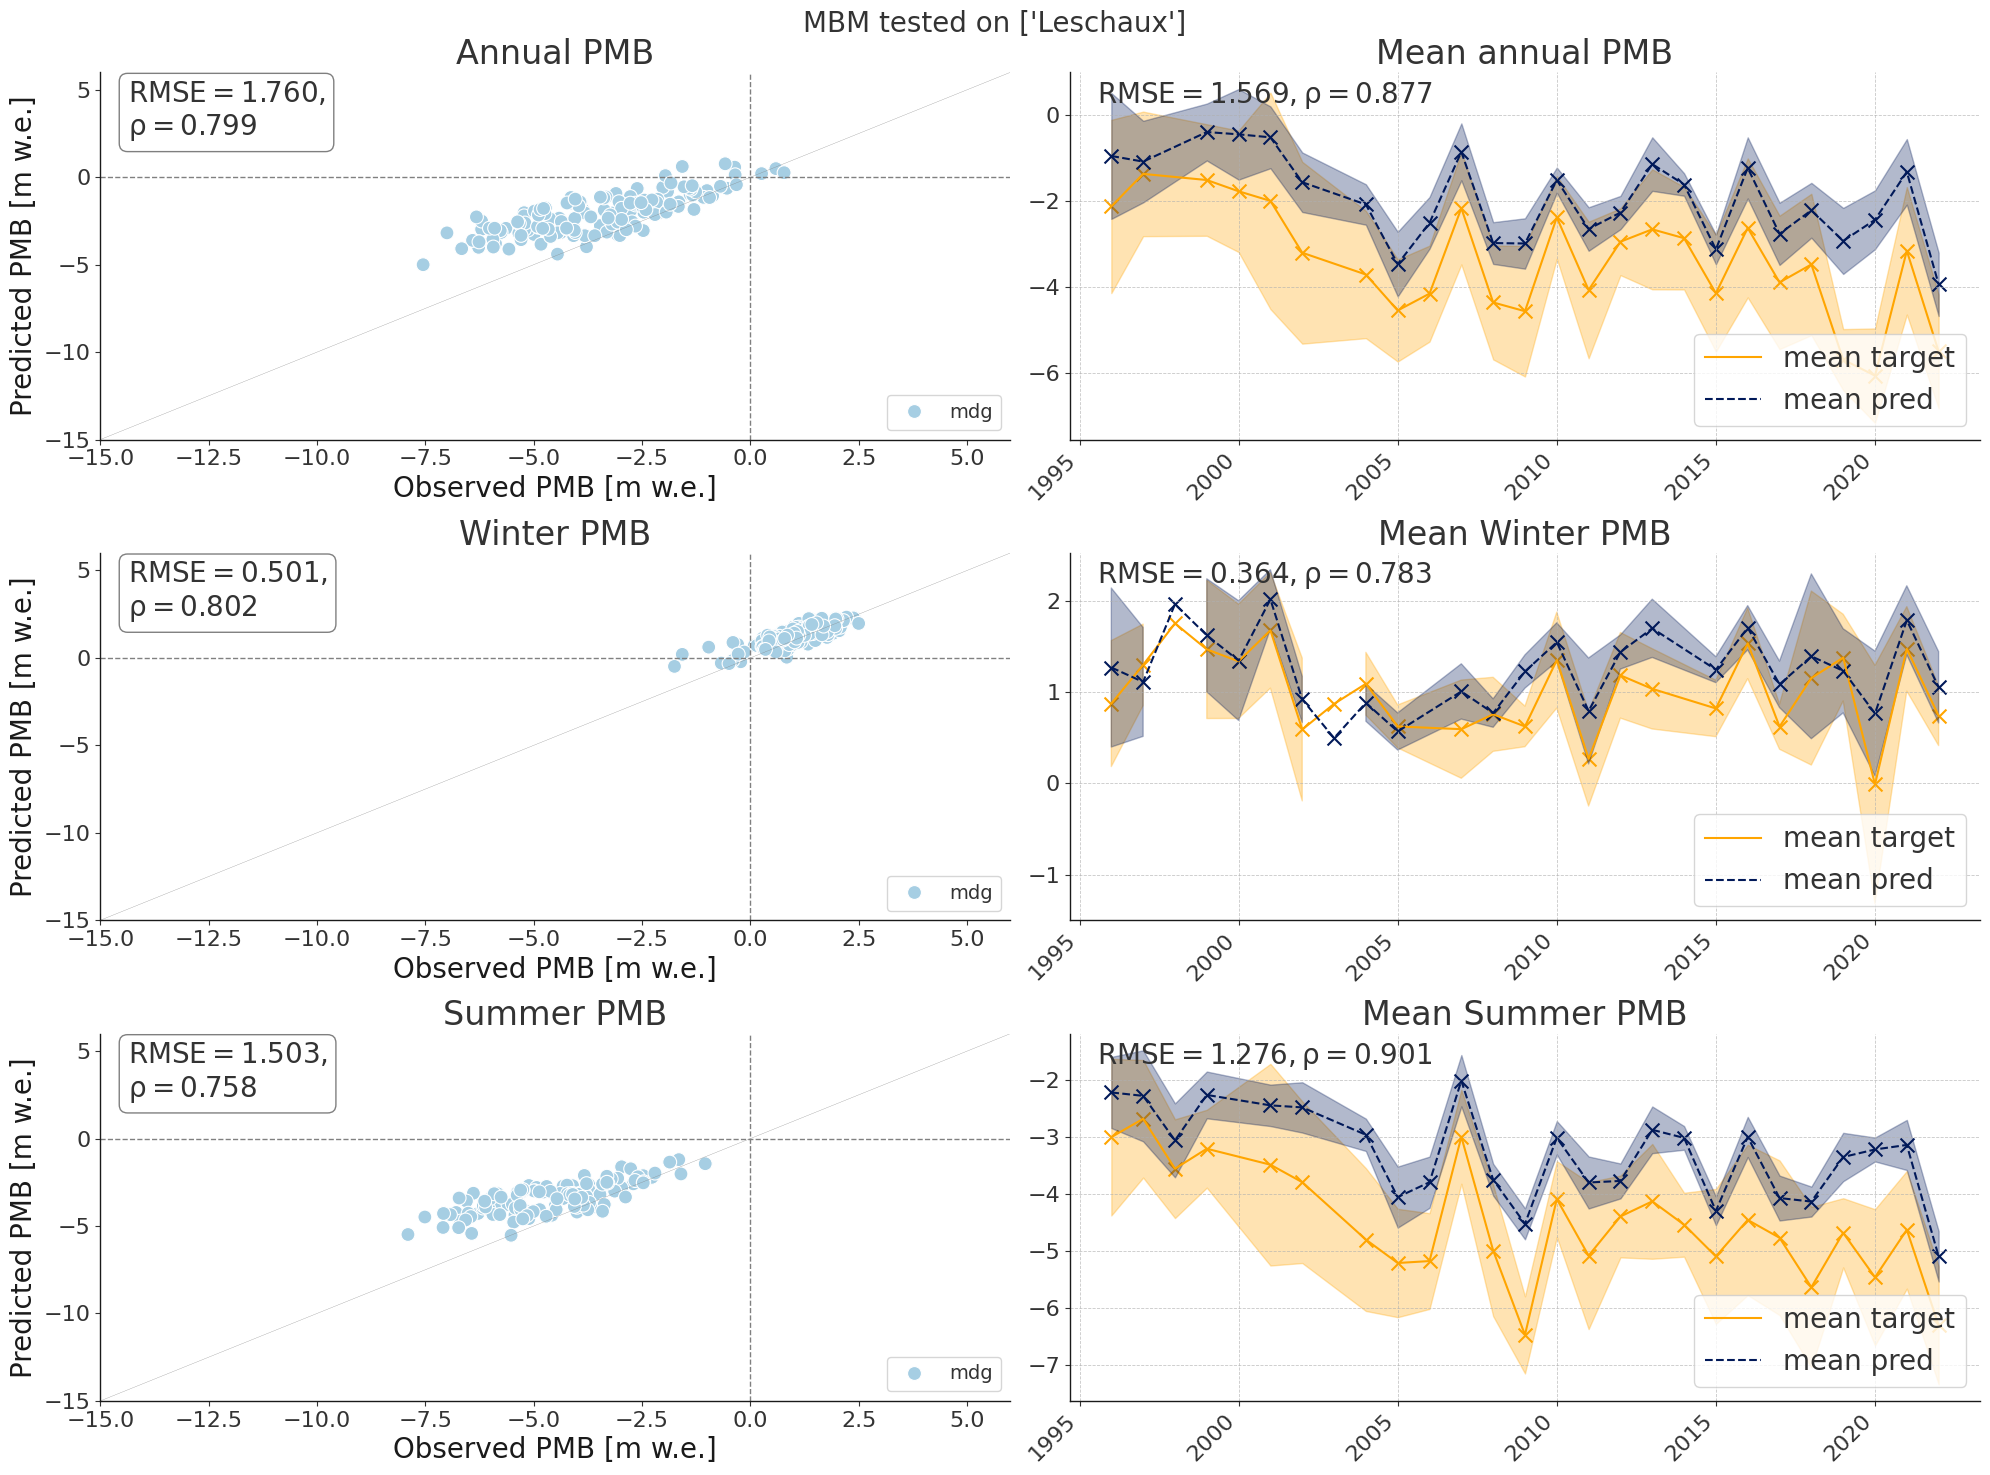

In [34]:
custom_params = {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 800}

# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

params = {**param_init, **custom_params}
print(params)
custom_model = mbm.models.CustomXGBoostRegressor(cfg, **params)

# Fit on train data:
custom_model.fit(train_set['df_X'][all_columns], train_set['y'])

# Make predictions on test
custom_model = custom_model.set_params(device='cpu')
features_test, metadata_test = custom_model._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = custom_model.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = custom_model.aggrPredict(metadata_test, features_test)

# Calculate scores
score = custom_model.score(test_set['df_X'][all_columns],
                           test_set['y'])  # negative
print('Overall score:', np.abs(score))

grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set, custom_model)
plt.suptitle(f'MBM tested on {test_glaciers}', fontsize=20)
plt.tight_layout()

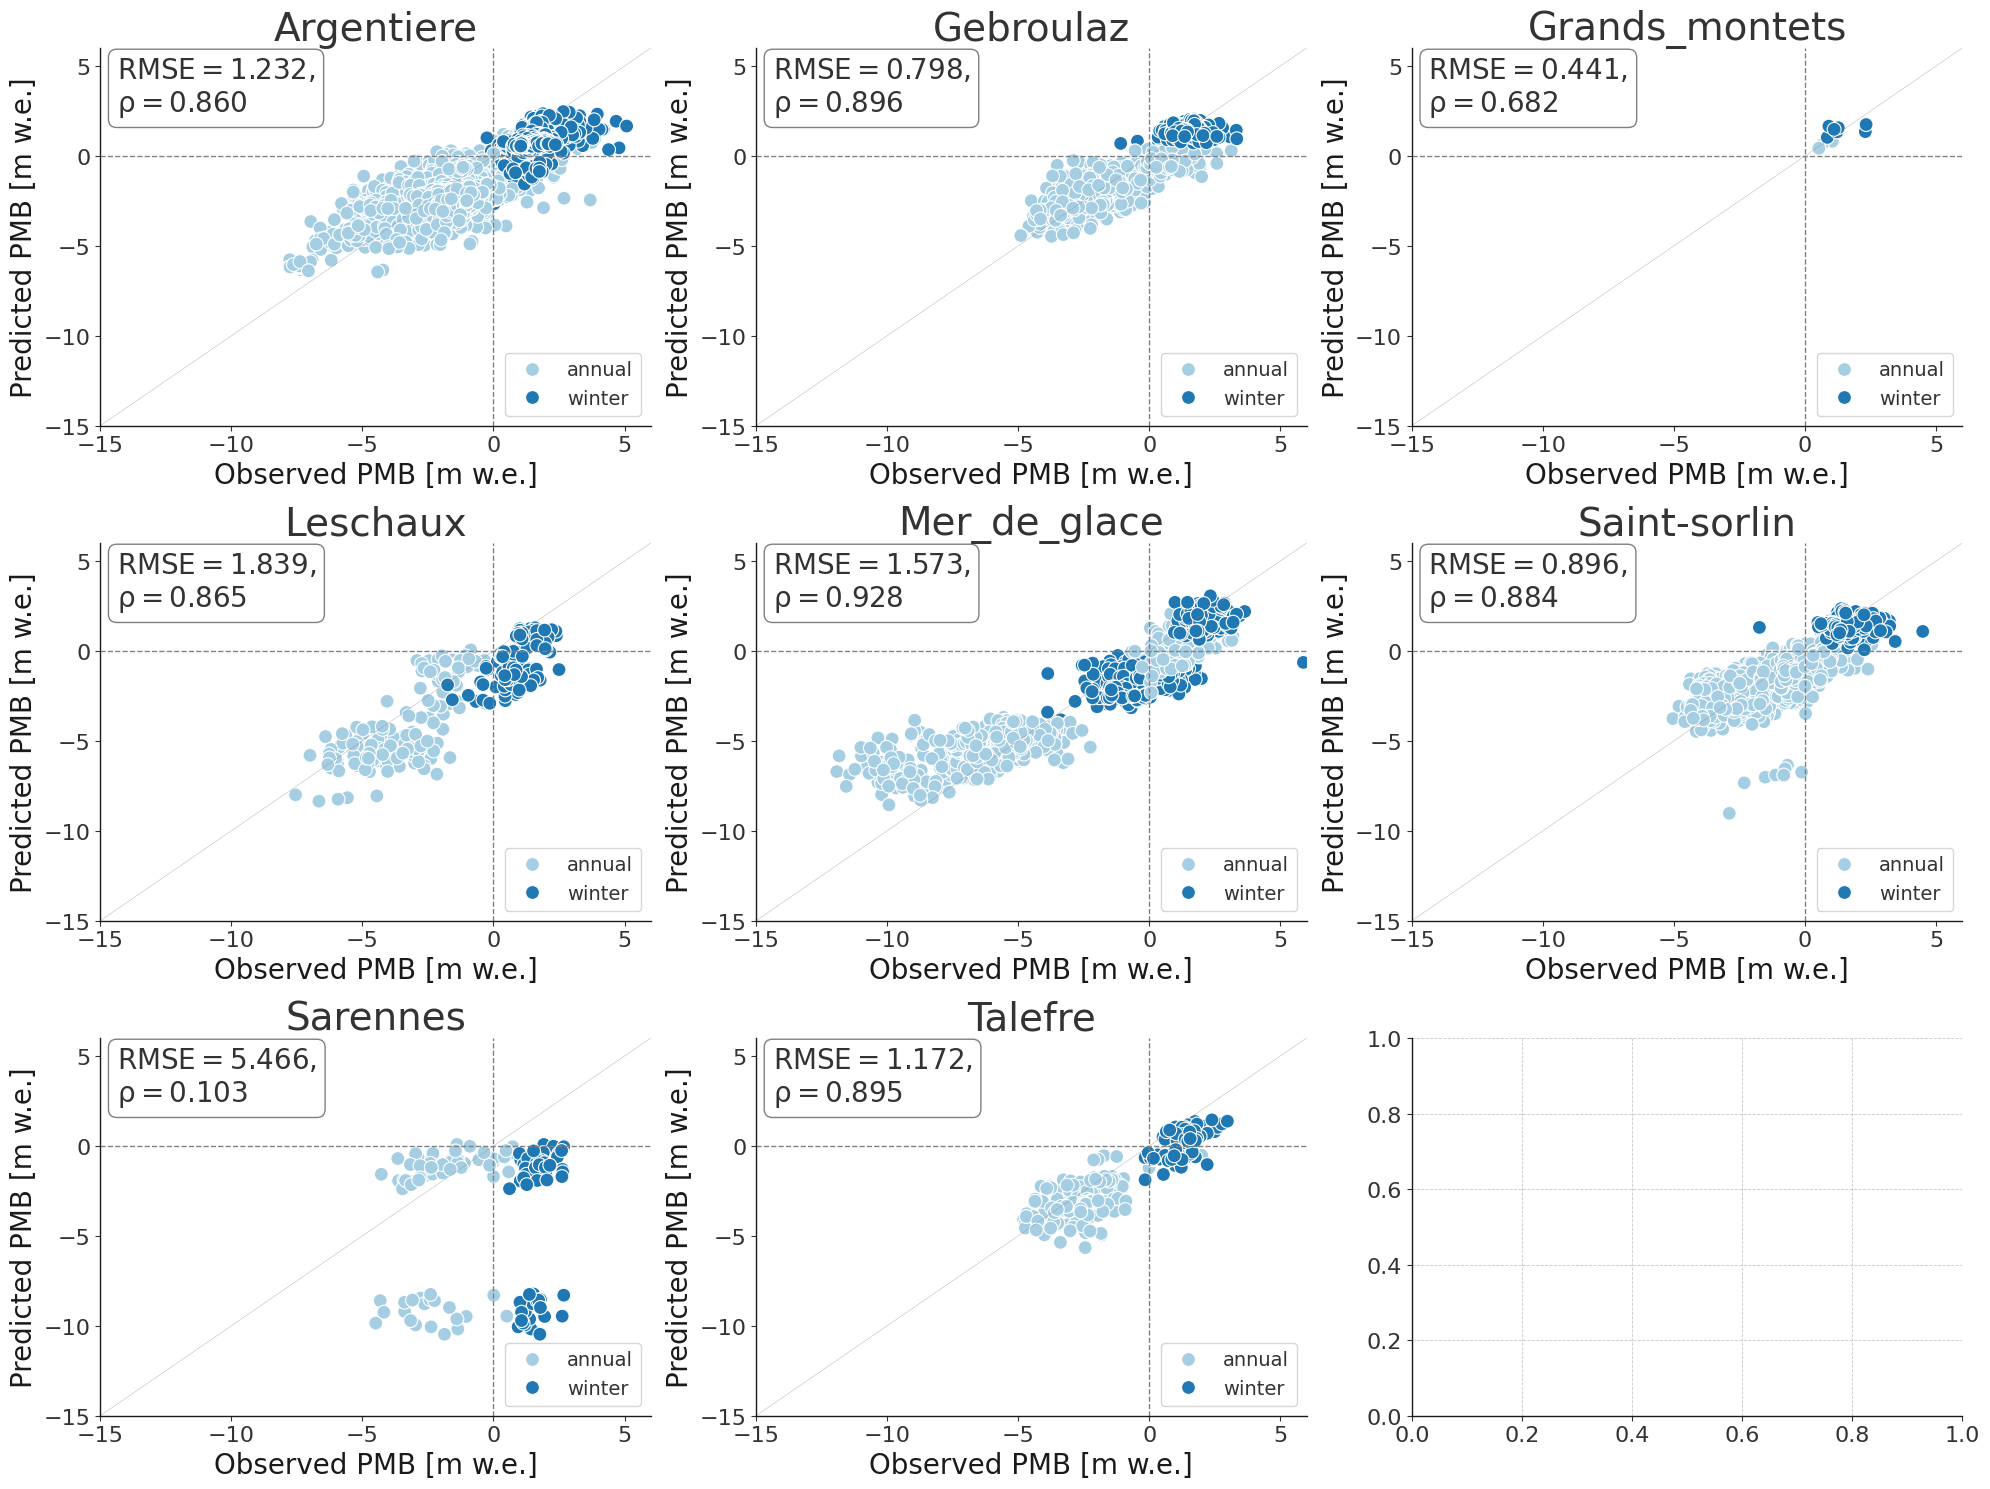

In [36]:
# Aggregate predictions to annual or winter:
PlotIndividualGlacierPredVsTruth(grouped_ids, figsize=(20, 15))

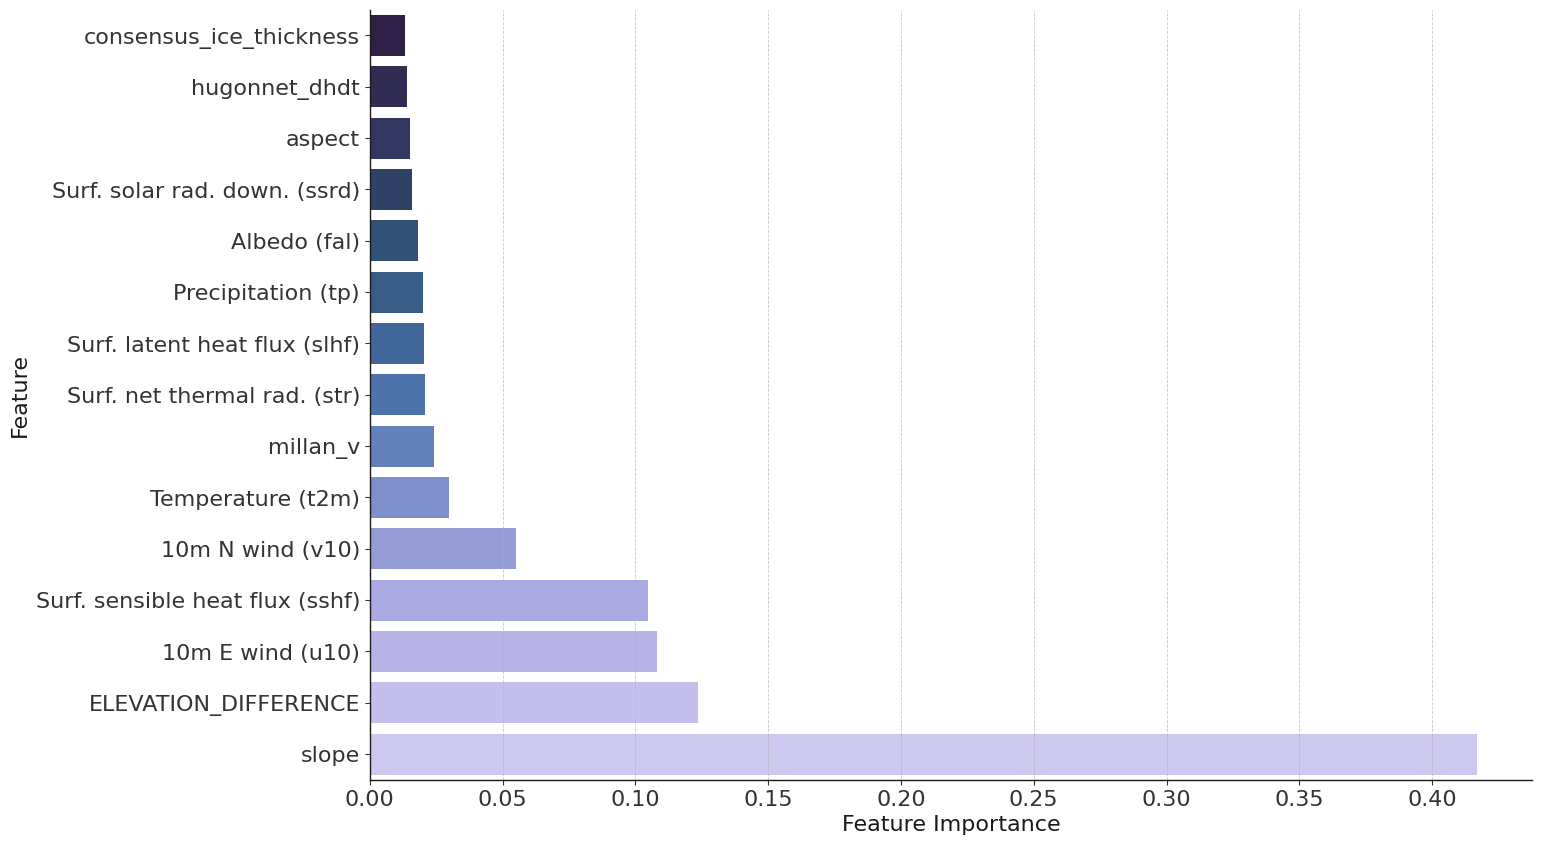

In [26]:
FIPlot(custom_model, feature_columns, vois_climate)

## Extrapolate in space


### Geodetic MB:

In [ ]:
# read geodetic MB:
geodeticMB = pd.read_csv(path_geodetic_MB_glamos + 'dV_DOI2024_allcomb.csv')

# filter to glaciers
all_gl = dataloader_gl.data.GLACIER.unique()

# get rgi of those glaciers:
rgi_gl = data_glamos[data_glamos.GLACIER.isin(all_gl)].RGIId.unique()
sgi_gl = [
    rgi_df[rgi_df['rgi_id.v6'] == rgi]['sgi-id'].values[0] for rgi in rgi_gl
]
geodeticMB = geodeticMB[geodeticMB['SGI-ID'].isin(sgi_gl)]

# Add glacierName to geodeticMB
# based  on SGI-ID
glacierNames = [
    rgi_df[rgi_df['sgi-id'] == sgi_id].index[0]
    for sgi_id in geodeticMB['SGI-ID'].values
]
geodeticMB['glacierName'] = glacierNames

# replace claridenL by clariden
geodeticMB['glacierName'] = geodeticMB['glacierName'].apply(
    lambda x: 'clariden' if x == 'claridenL' else x)

# get years per glacier
years_start_per_gl = geodeticMB.groupby(
    'glacierName')['Astart'].unique().apply(list).to_dict()
years_end_per_gl = geodeticMB.groupby('glacierName')['A_end'].unique().apply(
    list).to_dict()

periods_per_glacier = defaultdict(list)
geoMB_per_glacier = defaultdict(list)
# Iterate through the DataFrame rows
for _, row in geodeticMB.iterrows():
    glacierName = row['glacierName']
    start_year = row['Astart']
    end_year = row['A_end']
    geoMB = row['Bgeod']

    # Append the (start, end) tuple to the glacier's list
    periods_per_glacier[glacierName].append((start_year, end_year))
    geoMB_per_glacier[glacierName].append(geoMB)

### Glacier wide MB: 
Compute 2D fields.

#### List of glaciers to compute:

In [ ]:
glDirect = [
    re.search(r'xr_direct_(.*?)\.nc', f).group(1)
    for f in os.listdir(path_pcsr + 'csv/')
]
data_glamos = data_glamos[data_glamos.GLACIER.isin(glDirect)]
glacier_list = list(data_glamos.GLACIER.unique())
print('Number of glaciers with pcsr:', len(glacier_list))

satellite_glaciers = [
    'adler', 'aletsch', 'allalin', 'basodino', 'clariden', 'findelen', 'gries',
    'hohlaub', 'limmern', 'oberaar', 'plattalva', 'rhone', 'sanktanna',
    'schwarzbach', 'schwarzberg'
]
geodetic_glaciers = geodeticMB.glacierName.unique()
print('Number of glaciers with geodetic MB:', len(geodetic_glaciers))

# Intersection of both
common_glaciers = list(set(geodetic_glaciers) & set(glacier_list))
print('Number of common glaciers:', len(common_glaciers))

# Sort glaciers by area
gl_area = get_gl_area()
gl_area['clariden'] = gl_area['claridenL']


# Sort the lists by area if available in gl_area
def sort_by_area(glacier_list, gl_area):
    return sorted(glacier_list, key=lambda g: gl_area.get(g, 0), reverse=False)


glacier_list = sort_by_area(common_glaciers, gl_area)
glacier_list

### GLAMOS grids:

### Normal T & P:

In [ ]:
RUN = True
if RUN:
    # Define paths
    path_save_glw = 'results/nc/glamos/OGGM_vars/TP_T2m/'
    path_xr_grids = '/home/mburlet/scratch/data/DATA_MB/GLACIOCLIM/topo/GLAMOS_DEM/xr_masked_grids/'  # GLAMOS DEMs

    emptyfolder(path_save_glw)

    # Feature columns
    vois_climate = [
        't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
    ]
    feature_columns = [
        'ELEVATION_DIFFERENCE'
    ] + list(vois_climate) + list(vois_topographical)
    all_columns = feature_columns + cfg.fieldsNotFeatures
    print('Running for feature columns:', all_columns)

    for glacier_name in glacier_list:
        glacier_path = os.path.join(path_glacier_grid_glamos, glacier_name)

        if not os.path.exists(glacier_path):
            print(f"Folder not found for {glacier_name}, skipping...")
            continue

        glacier_files = sorted(
            [f for f in os.listdir(glacier_path) if glacier_name in f])

        print(f"Processing {glacier_name} ({len(glacier_files)} files)")

        for file_name in tqdm(glacier_files,
                              desc=f"Processing {glacier_name}",
                              leave=False):
            year = int(file_name.split('_')[2].split('.')[0])
            # process_glacier_file(cfg, custom_model, glacier_name, file_name,
            #                      path_save_glw, path_xr_grids, all_columns)

            # Load parquet input glacier grid file in monthly format (pre-processed)
            df_grid_monthly = pd.read_parquet(
                os.path.join(path_glacier_grid_glamos, glacier_name,
                             file_name))
            df_grid_monthly.drop_duplicates(inplace=True)

            # Keep only necessary columns, avoiding missing columns issues
            df_grid_monthly = df_grid_monthly[[
                col for col in all_columns if col in df_grid_monthly.columns
            ]]

            # Create geodata object
            geoData = mbm.GeoData(df_grid_monthly)

            # Computes and saves gridded MB for a year and glacier
            geoData.gridded_MB_pred(custom_model,
                                    glacier_name,
                                    year,
                                    all_columns,
                                    path_xr_grids,
                                    path_save_glw,
                                    cfg,
                                    save_monthly_pred=True)


In [ ]:
glacier_name = 'clariden'
year = 1951
# open xarray
xr.open_dataset(
    path_save_glw +
    f'{glacier_name}/{glacier_name}_{year}_annual.zarr').pred_masked.plot()